# Data translation model
This model takes inputs captured from EMG and NIR sensor

In [1]:
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.layers import GRU, Embedding, Conv1D, TimeDistributed, Flatten, Dropout, MaxPool1D
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K

Using TensorFlow backend.


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import random

import serial
import time

In [3]:
channel = 8
window_size = 300

In [4]:

signal = []
hand = []

with open("generated-input.txt", "r") as sig:
    for line in sig:
        line = line.split(",")
        signal.append([float(val) for val in line[:8]])
        hand.append([float(val) for val in line[8:16]])
        
signal = np.reshape(signal, (len(signal), 8))
hand = np.reshape(hand, (len(signal), 8))


In [32]:
signal[:10]

array([[2.100e+02, 2.670e+03, 2.910e+02, 1.382e+03, 1.151e+03, 4.060e+03,
        7.740e+02, 3.657e+03],
       [2.210e+02, 1.356e+03, 3.010e+02, 2.615e+03, 3.525e+03, 3.528e+03,
        3.500e+03, 2.300e+01],
       [3.577e+03, 2.050e+02, 1.207e+03, 1.236e+03, 2.079e+03, 1.384e+03,
        1.080e+02, 2.905e+03],
       [1.259e+03, 1.640e+03, 3.889e+03, 2.893e+03, 2.419e+03, 1.208e+03,
        3.892e+03, 3.944e+03],
       [1.992e+03, 3.756e+03, 2.303e+03, 8.200e+02, 2.040e+02, 1.492e+03,
        3.368e+03, 2.140e+03],
       [1.000e+00, 2.742e+03, 1.159e+03, 1.263e+03, 1.920e+02, 3.827e+03,
        1.909e+03, 4.160e+02],
       [1.215e+03, 3.680e+03, 2.345e+03, 3.966e+03, 2.146e+03, 3.492e+03,
        2.030e+03, 3.613e+03],
       [3.842e+03, 1.076e+03, 6.550e+02, 2.169e+03, 3.861e+03, 4.770e+02,
        3.143e+03, 3.920e+02],
       [3.491e+03, 1.332e+03, 3.909e+03, 3.440e+02, 1.232e+03, 1.251e+03,
        2.674e+03, 3.805e+03],
       [1.010e+03, 2.951e+03, 1.546e+03, 3.274e+03, 1.1

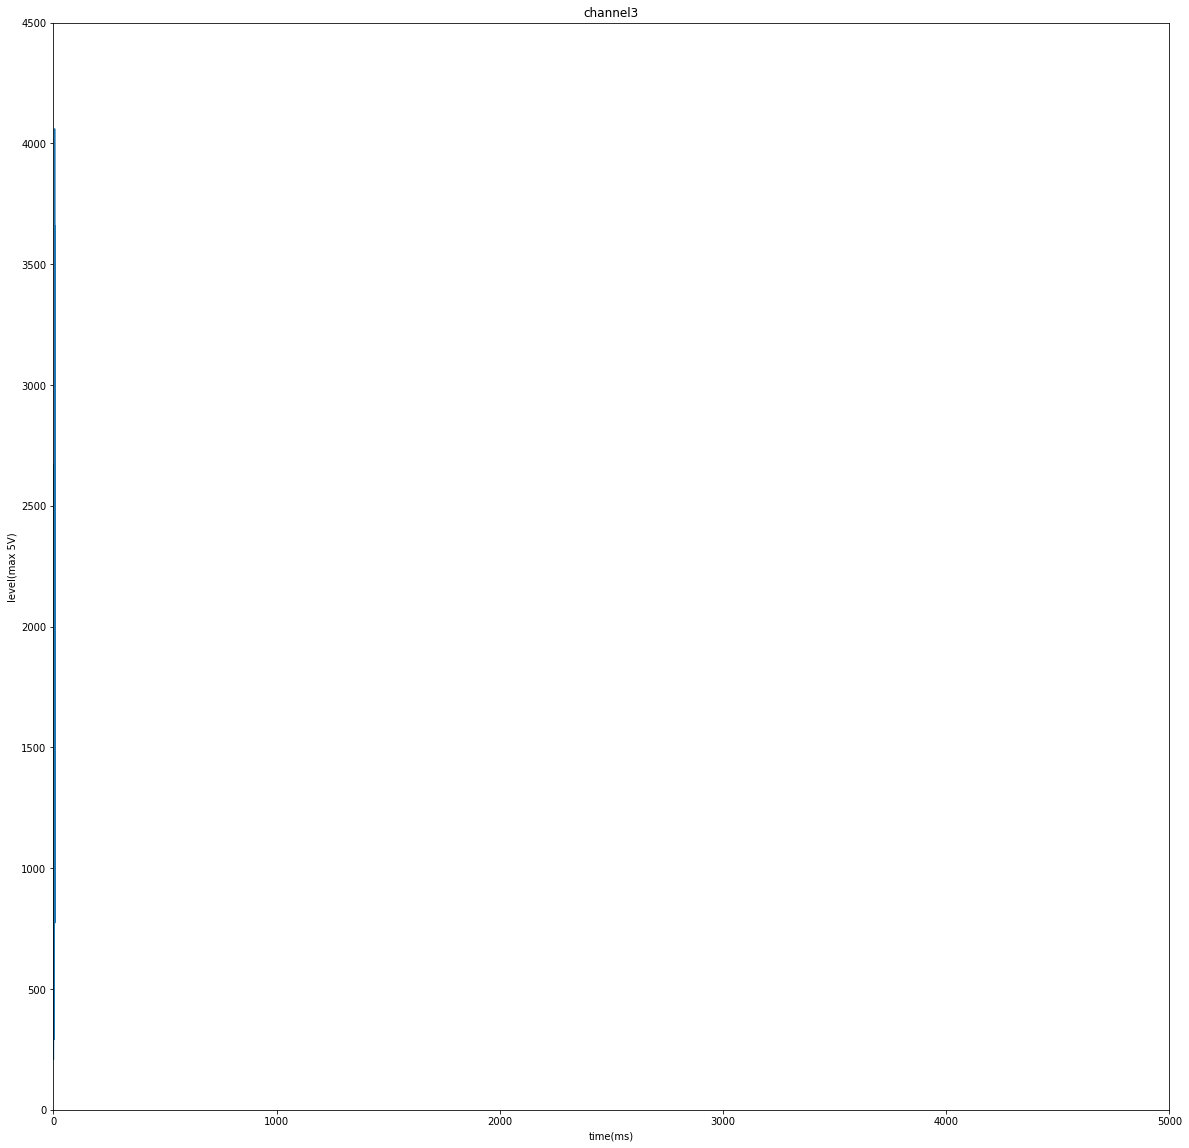

In [5]:
plt.figure(figsize=(20, 20))
plt.xlabel('time(ms)')
plt.ylabel('level(max 5V)')
plt.title('channel3')
plt.plot(signal[0])
plt.axis([0, 5000, 0, 4500])
plt.show()
# Axes3D.plot_wireframe(signal)

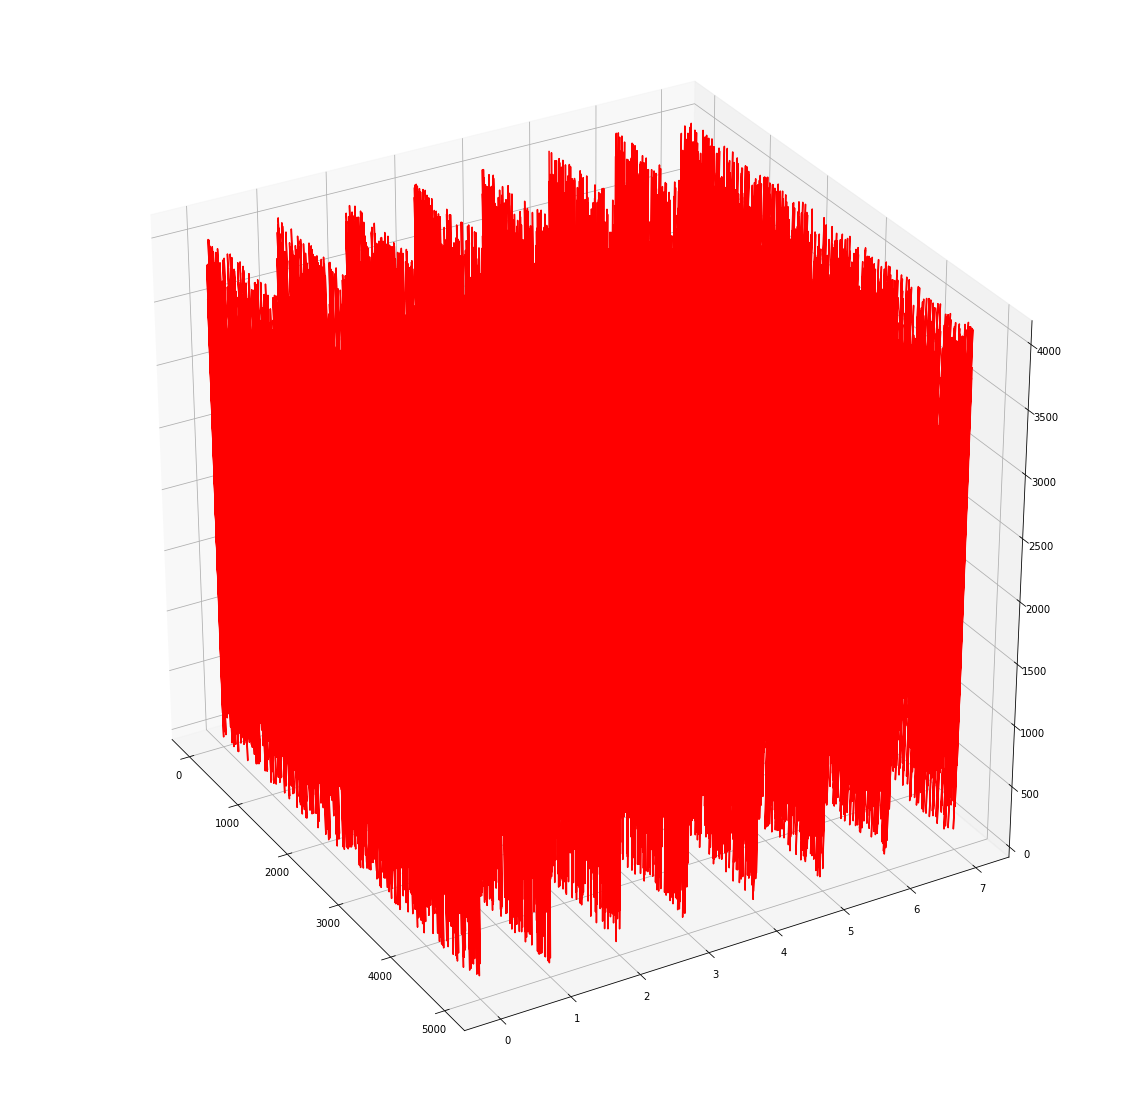

In [6]:

fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(20,20))

datasets = [{"x":np.arange(0, len(signal[:,i]), 1) , "z":signal[:,i], "y":[i for _ in range(len(signal[:,i]))], "colour": "red"} for i in range(8)]

ax.view_init(30, -30)

for dataset in datasets:
    ax.plot(dataset["x"], dataset["y"], dataset["z"], color=dataset["colour"])

plt.show()

In [7]:
emg = []
pot = []
for i in range(int(len(signal)/100)-3):
    emg.append(signal[100*i : 100*(i+3)])
    pot.append(hand[100*(i+3)])

emg = np.array(emg)
pot = np.array(pot)

print(pot[10:20])
# for i in emg:
#     print(i.shape)


[[ 576. 2714. 1535.   87.  629.  387. 4029.  929.]
 [ 793. 1170. 2676. 2798. 2288.   37. 2218. 2041.]
 [1663.  786. 2725. 2944. 3282. 1528. 3029. 3227.]
 [1025.  183. 3277. 2443.   37. 3838. 1121. 3735.]
 [2205. 1354. 1420. 1124. 1696. 3169. 2992. 2365.]
 [1325. 1051.  636.  517. 3814.  603. 1036.  616.]
 [1735. 1527.  880. 2795. 3923. 2804.  911. 2919.]
 [3634. 3223. 3450. 1675. 2650. 2369. 2359. 1712.]
 [3775. 3408. 3867.  496. 2448. 2616. 3950. 3861.]
 [2282.  832. 2592.  360. 3394. 2580. 3310. 3924.]]


In [8]:
from keras.layers import Conv2D, MaxPool2D

def getModel():
    
    input1 = Input(shape=(window_size,channel))
    x = Conv1D(64, 5, activation='relu')(input1)
    x = MaxPool1D()(x)
    x = Flatten()(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.3)(x)
    out = Dense(8, activation='relu')(x)
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(),
                  loss='binary_crossentropy',
                  metrics=['acc'])
    
    return model

In [9]:
action_model = getModel();
action_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 8)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           2624      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 148, 64)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9472)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               947300    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total para

In [10]:
print('start training')
verbose = 0
train_params = [(500, 50)]
for (epochs, batch_size) in train_params:
  print("train with {} epochs and {} batch size".format(epochs, batch_size))
  action_model.fit(emg, pot, epochs=epochs, batch_size=batch_size, verbose=verbose,)
#                            callbacks=callbacks_list_action,
#                            validation_data=(val_input_action, val_target_action_reduce))

start training
train with 500 epochs and 50 batch size


In [11]:
action_model._make_predict_function()
action_model.predict([[emg[5]]])

array([[     0.  , 283937.9 , 231998.95, 134368.42,      0.  ,      0.  ,
             0.  , 334917.66]], dtype=float32)

In [38]:
# close opened serial
if (ser):
    ser.close()

In [39]:
record_time = 5
nChannel = 16
nByte = nChannel*2
serial_port = 'COM5'

end_time = time.time() + record_time

try:
    ser = serial.Serial(serial_port, 500000)
except:
    ser.close()

samples = [0]
    
while True:
    sample = []
    x = ser.read(nByte)
    for channel in range(0,nByte,2):
        sample.append(int.from_bytes(x[channel:channel+2], byteorder='big', signed=False))
    samples.append(sample[:8])
    
#     print(samples)
    
    if len(samples) > 300:
        samples.pop(0)
        pred = action_model.predict([[samples]])
        print(pred)

[[     0.     86725.695  70619.63   40755.855      0.         0.
       0.    102052.97 ]]
[[     0.     86550.25   70476.125  40688.49       0.         0.
       0.    101837.96 ]]
[[     0.     86654.63   70574.53   40750.504      0.         0.
       0.    101953.43 ]]
[[     0.     86442.9    70453.875  40661.902      0.         0.
       0.    101741.07 ]]
[[     0.    86554.52  70548.84  40724.68      0.        0.        0.
  101865.78]]
[[     0.     86381.805  70407.09   40664.85       0.         0.
       0.    101702.67 ]]
[[     0.     86514.05   70492.33   40740.117      0.         0.
       0.    101875.266]]
[[     0.     86418.96   70410.875  40703.31       0.         0.
       0.    101808.38 ]]
[[     0.     86593.336  70550.09   40732.496      0.         0.
       0.    102028.375]]
[[     0.     86493.016  70478.81   40677.492      0.         0.
       0.    101951.555]]
[[     0.     86599.836  70579.16   40767.668      0.         0.
       0.    102086.64 ]]
[[    

[[     0.     86485.14   70469.87   40725.613      0.         0.
       0.    101841.305]]
[[     0.     86406.79   70402.18   40699.977      0.         0.
       0.    101788.97 ]]
[[     0.     86561.87   70526.016  40724.695      0.         0.
       0.    101994.195]]
[[     0.    86480.53  70471.45  40670.37      0.        0.        0.
  101933.74]]
[[     0.     86572.805  70558.53   40753.414      0.         0.
       0.    102056.18 ]]
[[     0.     86437.34   70444.42   40663.152      0.         0.
       0.    101924.02 ]]
[[     0.     86533.75   70539.87   40663.586      0.         0.
       0.    102060.414]]
[[     0.     86414.21   70479.92   40599.168      0.         0.
       0.    101938.1  ]]
[[     0.     86584.77   70601.9    40659.953      0.         0.
       0.    102049.34 ]]
[[     0.     86569.24   70556.64   40620.996      0.         0.
       0.    101932.016]]
[[     0.     86768.85   70681.85   40658.055      0.         0.
       0.    102078.48 ]]
[[    

       0.    101934.48 ]]
[[     0.     86523.41   70534.02   40661.457      0.         0.
       0.    102052.01 ]]
[[     0.     86429.55   70486.516  40608.023      0.         0.
       0.    101953.51 ]]
[[     0.     86570.68   70596.305  40653.824      0.         0.
       0.    102041.36 ]]
[[     0.     86579.16   70565.33   40623.832      0.         0.
       0.    101947.36 ]]
[[     0.    86753.98  70673.22  40653.57      0.        0.        0.
  102063.89]]
[[     0.     86712.82   70641.555  40611.402      0.         0.
       0.    101994.83 ]]
[[     0.     86812.83   70722.375  40695.418      0.         0.
       0.    102132.58 ]]
[[     0.    86659.34  70591.57  40687.13      0.        0.        0.
  101999.36]]
[[     0.     86690.06   70596.66   40736.996      0.         0.
       0.    102021.02 ]]
[[     0.     86554.28   70480.96   40687.027      0.         0.
       0.    101842.57 ]]
[[     0.     86622.19   70548.4    40733.387      0.         0.
       0.    

[[     0.     86744.56   70666.52   40624.395      0.         0.
       0.    102026.72 ]]
[[     0.     86810.59   70722.32   40687.227      0.         0.
       0.    102127.04 ]]
[[     0.     86691.92   70616.73   40701.715      0.         0.
       0.    102032.78 ]]
[[     0.     86688.984  70595.3    40734.13       0.         0.
       0.    102022.8  ]]
[[     0.    86585.77  70504.8   40704.03      0.        0.        0.
  101877.59]]
[[     0.     86619.95   70549.484  40728.508      0.         0.
       0.    101920.84 ]]
[[     0.    86485.76  70474.8   40686.92      0.        0.        0.
  101777.86]]
[[     0.     86505.85   70517.39   40699.387      0.         0.
       0.    101816.93 ]]
[[     0.     86424.29   70443.05   40681.145      0.         0.
       0.    101745.016]]
[[     0.     86473.84   70458.41   40721.016      0.         0.
       0.    101818.05 ]]
[[     0.     86443.6    70429.625  40719.637      0.         0.
       0.    101829.06 ]]
[[     0.    

[[     0.     86473.25   70461.85   40720.996      0.         0.
       0.    101822.61 ]]
[[     0.     86473.65   70452.74   40733.844      0.         0.
       0.    101860.89 ]]
[[     0.     86548.03   70519.49   40729.957      0.         0.
       0.    101978.81 ]]
[[     0.     86551.5    70526.88   40700.547      0.         0.
       0.    102005.6  ]]
[[     0.     86572.63   70556.34   40747.68       0.         0.
       0.    102055.805]]
[[     0.     86518.56   70508.52   40711.098      0.         0.
       0.    102015.06 ]]
[[     0.     86523.086  70532.36   40669.61       0.         0.
       0.    102055.195]]
[[     0.     86491.445  70534.82   40644.59       0.         0.
       0.    102026.44 ]]
[[     0.     86560.13   70596.8    40656.145      0.         0.
       0.    102045.76 ]]
[[     0.     86634.34   70613.125  40654.207      0.         0.
       0.    102022.72 ]]
[[     0.     86749.52   70673.03   40659.81       0.         0.
       0.    102067.414]]

[[     0.     86460.37   70489.914  40635.61       0.         0.
       0.    101907.836]]
[[     0.     86432.836  70508.625  40625.85       0.         0.
       0.    101890.85 ]]
[[     0.     86529.67   70587.836  40657.31       0.         0.
       0.    101980.1  ]]
[[     0.    86606.51  70591.71  40686.31      0.        0.        0.
  101995.83]]
[[     0.     86752.44   70648.99   40710.293      0.         0.
       0.    102118.73 ]]
[[     0.     86765.7    70643.52   40664.395      0.         0.
       0.    102121.555]]
[[     0.     86819.35   70684.     40695.832      0.         0.
       0.    102185.01 ]]
[[     0.     86734.84   70634.79   40709.902      0.         0.
       0.    102099.586]]
[[     0.     86723.89   70634.664  40753.         0.         0.
       0.    102072.81 ]]
[[     0.     86649.445  70588.01   40748.74       0.         0.
       0.    101960.52 ]]
[[     0.     86695.99   70648.94   40749.754      0.         0.
       0.    102010.07 ]]
[[    

[[     0.     86548.33   70446.914  40701.152      0.         0.
       0.    101811.1  ]]
[[     0.    86665.54  70574.3   40769.01      0.        0.        0.
  101958.28]]
[[     0.     86539.71   70527.16   40684.527      0.         0.
       0.    101878.734]]
[[     0.     86687.04   70668.234  40774.285      0.         0.
       0.    102094.04 ]]
[[     0.     86623.58   70610.73   40729.926      0.         0.
       0.    102065.81 ]]
[[     0.     86767.305  70719.055  40833.777      0.         0.
       0.    102272.72 ]]
[[     0.     86750.71   70694.58   40789.348      0.         0.
       0.    102279.06 ]]
[[     0.    86927.39  70807.01  40833.07      0.        0.        0.
  102420.03]]
[[     0.     86808.016  70712.49   40825.492      0.         0.
       0.    102278.9  ]]
[[     0.    86903.11  70778.74  40867.45      0.        0.        0.
  102334.8 ]]
[[     0.     86739.55   70692.69   40744.816      0.         0.
       0.    102183.086]]
[[     0.     86804.

[[     0.     86769.2    70717.305  40855.766      0.         0.
       0.    102104.01 ]]
[[     0.     86809.24   70763.5    40856.727      0.         0.
       0.    102159.586]]
[[     0.     86821.     70773.32   40832.         0.         0.
       0.    102159.766]]
[[     0.    86855.91  70796.77  40832.4       0.        0.        0.
  102248.64]]
[[     0.     86818.42   70778.29   40857.008      0.         0.
       0.    102228.6  ]]
[[     0.    86764.56  70752.66  40851.48      0.        0.        0.
  102227.79]]
[[     0.     86756.54   70705.52   40880.41       0.         0.
       0.    102248.914]]
[[     0.    86816.08  70707.82  40901.08      0.        0.        0.
  102344.05]]
[[     0.     86818.38   70669.29   40807.082      0.         0.
       0.    102344.94 ]]
[[     0.     86804.336  70698.13   40804.02       0.         0.
       0.    102368.13 ]]
[[     0.     86727.99   70680.21   40766.688      0.         0.
       0.    102304.45 ]]
[[     0.     86740.

[[     0.     86993.836  70909.46   40873.348      0.         0.
       0.    102359.89 ]]
[[     0.     87027.38   70921.73   40886.992      0.         0.
       0.    102418.65 ]]
[[     0.     86996.76   70898.516  40882.906      0.         0.
       0.    102407.04 ]]
[[     0.     86991.79   70874.78   40935.203      0.         0.
       0.    102343.695]]
[[     0.     87013.93   70910.48   40918.625      0.         0.
       0.    102378.016]]
[[     0.    87025.97  70913.03  40907.44      0.        0.        0.
  102405.7 ]]
[[     0.    86999.28  70899.18  40903.63      0.        0.        0.
  102443.31]]
[[     0.     86973.17   70848.39   40918.016      0.         0.
       0.    102421.73 ]]
[[     0.     86871.96   70737.98   40910.066      0.         0.
       0.    102343.67 ]]
[[     0.     86828.3    70686.57   40918.816      0.         0.
       0.    102291.87 ]]
[[     0.     86862.195  70721.766  40926.383      0.         0.
       0.    102330.47 ]]
[[     0.    

[[     0.     86996.9    70831.11   40865.445      0.         0.
       0.    102404.555]]
[[     0.     87147.055  71018.17   40945.246      0.         0.
       0.    102568.36 ]]
[[     0.     86999.71   70944.84   40861.934      0.         0.
       0.    102405.19 ]]
[[     0.     87165.94   71076.89   40994.992      0.         0.
       0.    102623.24 ]]
[[     0.     86969.945  70903.59   40901.098      0.         0.
       0.    102479.516]]
[[     0.    87083.39  70944.9   41033.63      0.        0.        0.
  102617.92]]
[[     0.    86969.98  70818.68  40928.83      0.        0.        0.
  102493.97]]
[[     0.     87091.32   70916.47   40959.035      0.         0.
       0.    102571.28 ]]
[[     0.     86903.305  70752.375  40893.605      0.         0.
       0.    102342.61 ]]
[[     0.     86908.56   70864.94   40911.184      0.         0.
       0.    102378.35 ]]
[[     0.    86685.72  70717.93  40776.99      0.        0.        0.
  102135.48]]
[[     0.     86798.

[[     0.     86964.37   70860.52   40916.12       0.         0.
       0.    102451.086]]
[[     0.     86855.23   70808.86   40822.434      0.         0.
       0.    102361.05 ]]
[[     0.    86889.79  70886.87  40841.3       0.        0.        0.
  102458.52]]
[[     0.     86792.23   70821.35   40835.84       0.         0.
       0.    102383.414]]
[[     0.     86938.02   70880.37   40898.402      0.         0.
       0.    102473.53 ]]
[[     0.     86893.41   70820.34   40846.598      0.         0.
       0.    102330.18 ]]
[[     0.     87004.13   70887.14   40824.035      0.         0.
       0.    102378.31 ]]
[[     0.     86888.81   70779.14   40727.133      0.         0.
       0.    102224.2  ]]
[[     0.     86914.414  70786.164  40812.35       0.         0.
       0.    102249.57 ]]
[[     0.     86773.83   70666.69   40795.176      0.         0.
       0.    102095.125]]
[[     0.     86865.32   70714.195  40844.836      0.         0.
       0.    102154.016]]
[[    

[[     0.     86608.445  70558.414  40732.19       0.         0.
       0.    102037.516]]
[[     0.     86650.04   70638.195  40776.066      0.         0.
       0.    102096.12 ]]
[[     0.    86601.24  70639.96  40746.34      0.        0.        0.
  102083.66]]
[[     0.    86671.74  70697.06  40757.22      0.        0.        0.
  102182.08]]
[[     0.     86658.04   70699.734  40760.836      0.         0.
       0.    102191.09 ]]
[[     0.     86764.19   70734.89   40785.145      0.         0.
       0.    102241.516]]
[[     0.     86796.27   70732.805  40751.51       0.         0.
       0.    102255.92 ]]
[[     0.    86855.38  70772.77  40754.53      0.        0.        0.
  102297.14]]
[[     0.     86836.04   70770.99   40758.52       0.         0.
       0.    102261.125]]
[[     0.     86903.73   70814.945  40766.145      0.         0.
       0.    102290.12 ]]
[[     0.     86849.54   70773.336  40743.57       0.         0.
       0.    102196.18 ]]
[[     0.     86871.

[[     0.     86976.51   70850.07   40826.285      0.         0.
       0.    102323.08 ]]
[[     0.     86746.37   70683.2    40818.332      0.         0.
       0.    102088.766]]
[[     0.     86827.625  70738.51   40919.13       0.         0.
       0.    102177.61 ]]
[[     0.    86719.54  70654.51  40822.3       0.        0.        0.
  102047.04]]
[[     0.     86900.82   70778.26   40847.527      0.         0.
       0.    102251.28 ]]
[[     0.     86778.29   70706.11   40769.98       0.         0.
       0.    102120.266]]
[[     0.     86923.49   70844.88   40840.504      0.         0.
       0.    102301.65 ]]
[[     0.     86725.45   70714.18   40770.508      0.         0.
       0.    102174.95 ]]
[[     0.    86773.54  70729.26  40874.64      0.        0.        0.
  102285.69]]
[[     0.     86675.42   70593.8    40837.133      0.         0.
       0.    102178.58 ]]
[[     0.    86824.39  70696.09  40876.24      0.        0.        0.
  102348.27]]
[[     0.     86666.

[[     0.     87001.37   70889.305  40952.46       0.         0.
       0.    102490.64 ]]
[[     0.     86994.28   70905.57   41013.895      0.         0.
       0.    102480.66 ]]
[[     0.     86918.09   70831.11   40937.316      0.         0.
       0.    102402.1  ]]
[[     0.     86930.52   70856.24   40839.664      0.         0.
       0.    102476.734]]
[[     0.     86826.19   70823.16   40751.637      0.         0.
       0.    102413.63 ]]
[[     0.     86860.84   70859.39   40800.133      0.         0.
       0.    102436.92 ]]
[[     0.     86899.1    70894.22   40764.887      0.         0.
       0.    102419.9  ]]
[[     0.     87038.555  70971.766  40762.664      0.         0.
       0.    102513.29 ]]
[[     0.     87096.266  70980.445  40756.93       0.         0.
       0.    102543.37 ]]
[[     0.     87190.04   71033.43   40827.113      0.         0.
       0.    102641.62 ]]
[[     0.     87144.15   70981.586  40879.355      0.         0.
       0.    102579.484]]

[[     0.    86772.82  70731.34  40855.77      0.        0.        0.
  102143.99]]
[[     0.     86720.36   70656.36   40840.758      0.         0.
       0.    102090.79 ]]
[[     0.     86784.65   70694.96   40901.227      0.         0.
       0.    102209.875]]
[[     0.     86793.94   70717.08   40860.152      0.         0.
       0.    102275.445]]
[[     0.     86876.914  70781.77   40855.84       0.         0.
       0.    102381.59 ]]
[[     0.     86819.1    70742.2    40873.324      0.         0.
       0.    102341.12 ]]
[[     0.     86836.87   70767.22   40882.363      0.         0.
       0.    102370.36 ]]
[[     0.    86766.08  70730.99  40787.47      0.        0.        0.
  102328.75]]
[[     0.     86798.9    70775.17   40788.676      0.         0.
       0.    102378.625]]
[[     0.     86765.87   70768.734  40753.125      0.         0.
       0.    102304.53 ]]
[[     0.     86944.34   70855.94   40812.574      0.         0.
       0.    102368.78 ]]
[[     0.    

[[     0.     87098.055  70969.45   40838.5        0.         0.
       0.    102453.164]]
[[     0.    87016.66  70922.64  40774.55      0.        0.        0.
  102407.29]]
[[     0.     87026.49   70880.79   40872.902      0.         0.
       0.    102412.055]]
[[     0.     86871.39   70727.375  40835.996      0.         0.
       0.    102274.53 ]]
[[     0.     86904.42   70743.8    40849.863      0.         0.
       0.    102330.05 ]]
[[     0.     86843.31   70688.83   40852.348      0.         0.
       0.    102279.44 ]]
[[     0.     86844.42   70697.91   40867.035      0.         0.
       0.    102311.03 ]]
[[     0.     86713.05   70664.625  40821.59       0.         0.
       0.    102186.91 ]]
[[     0.     86746.64   70743.31   40839.742      0.         0.
       0.    102253.09 ]]
[[     0.     86708.695  70737.64   40789.28       0.         0.
       0.    102208.914]]
[[     0.     86845.21   70851.086  40831.35       0.         0.
       0.    102357.8  ]]
[[    

[[     0.     87493.11   71260.266  41195.453      0.         0.
       0.    102968.62 ]]
[[     0.    87490.89  71264.42  41149.28      0.        0.        0.
  102979.31]]
[[     0.     87511.12   71274.65   41208.957      0.         0.
       0.    103005.21 ]]
[[     0.     87392.06   71189.664  41152.99       0.         0.
       0.    102943.09 ]]
[[     0.     87454.555  71216.586  41135.855      0.         0.
       0.    103028.7  ]]
[[     0.     87422.29   71150.914  41094.527      0.         0.
       0.    102962.18 ]]
[[     0.     87427.54   71163.56   41049.184      0.         0.
       0.    102937.02 ]]
[[     0.     87285.01   71098.67   41014.402      0.         0.
       0.    102777.06 ]]
[[     0.     87235.305  71082.78   41026.426      0.         0.
       0.    102752.07 ]]
[[     0.    87038.91  70983.42  40907.31      0.        0.        0.
  102583.71]]
[[     0.     87092.19   71040.68   40907.617      0.         0.
       0.    102649.516]]
[[     0.    

[[     0.     87234.93   71093.47   41057.086      0.         0.
       0.    102788.43 ]]
[[     0.     87027.18   70951.42   40943.652      0.         0.
       0.    102563.664]]
[[     0.     87143.875  71030.99   40966.977      0.         0.
       0.    102637.98 ]]
[[     0.     87100.52   70976.195  40909.363      0.         0.
       0.    102547.63 ]]
[[     0.     87270.47   71079.49   40904.348      0.         0.
       0.    102687.11 ]]
[[     0.     87214.1    71025.805  40832.64       0.         0.
       0.    102644.62 ]]
[[     0.     87278.52   71085.78   40920.434      0.         0.
       0.    102768.04 ]]
[[     0.     87128.62   70952.23   40894.004      0.         0.
       0.    102630.26 ]]
[[     0.     87271.086  71030.484  40956.17       0.         0.
       0.    102734.016]]
[[     0.     87174.93   70979.086  40884.363      0.         0.
       0.    102599.53 ]]
[[     0.     87305.76   71092.586  40979.7        0.         0.
       0.    102710.47 ]]

[[     0.     86770.445  70674.3    40774.152      0.         0.
       0.    102083.99 ]]
[[     0.     86727.14   70649.91   40777.145      0.         0.
       0.    102061.15 ]]
[[     0.     86622.7    70598.84   40789.684      0.         0.
       0.    101964.72 ]]
[[     0.     86572.6    70554.414  40789.145      0.         0.
       0.    101931.8  ]]
[[     0.     86589.52   70549.914  40802.27       0.         0.
       0.    101966.664]]
[[     0.    86646.26  70585.51  40809.46      0.        0.        0.
  102096.51]]
[[     0.     86693.89   70622.62   40780.434      0.         0.
       0.    102146.414]]
[[     0.     86700.51   70673.125  40779.28       0.         0.
       0.    102195.945]]
[[     0.     86693.77   70686.73   40793.832      0.         0.
       0.    102200.35 ]]
[[     0.     86694.93   70676.35   40808.645      0.         0.
       0.    102231.76 ]]
[[     0.     86694.75   70684.93   40736.207      0.         0.
       0.    102276.21 ]]
[[    

[[     0.    87009.31  70824.62  40936.        0.        0.        0.
  102357.06]]
[[     0.    86765.73  70652.19  40819.66      0.        0.        0.
  102097.94]]
[[     0.     86970.46   70855.39   40933.066      0.         0.
       0.    102333.33 ]]
[[     0.     86698.516  70684.81   40774.2        0.         0.
       0.    102075.18 ]]
[[     0.     86924.74   70844.29   40925.035      0.         0.
       0.    102353.836]]
[[     0.    86645.2   70598.53  40797.62      0.        0.        0.
  102075.85]]
[[     0.     86813.7    70696.29   40888.3        0.         0.
       0.    102317.445]]
[[     0.    86629.53  70563.97  40762.17      0.        0.        0.
  102173.11]]
[[     0.    86930.75  70781.31  40846.92      0.        0.        0.
  102443.22]]
[[     0.    86723.48  70639.18  40742.06      0.        0.        0.
  102208.9 ]]
[[     0.    86907.71  70829.81  40876.47      0.        0.        0.
  102387.46]]
[[     0.     86652.41   70656.82   40736.824   

[[     0.    87322.93  71169.62  40992.42      0.        0.        0.
  102804.43]]
[[     0.    87572.01  71398.51  41145.73      0.        0.        0.
  103133.06]]
[[     0.     87263.54   71173.625  41021.98       0.         0.
       0.    102783.11 ]]
[[     0.     87561.516  71375.445  41196.637      0.         0.
       0.    103107.51 ]]
[[     0.     87281.664  71164.87   41077.41       0.         0.
       0.    102859.64 ]]
[[     0.    87538.58  71352.12  41135.69      0.        0.        0.
  103213.74]]
[[     0.    87172.72  71051.77  41033.2       0.        0.        0.
  102772.23]]
[[     0.     87357.695  71205.805  41133.363      0.         0.
       0.    102914.97 ]]
[[     0.     87010.76   70950.484  40987.633      0.         0.
       0.    102526.125]]
[[     0.     87278.35   71169.7    41070.254      0.         0.
       0.    102842.42 ]]
[[     0.     86978.086  70933.62   40917.348      0.         0.
       0.    102561.95 ]]
[[     0.     87270.13   71

[[     0.    87515.58  71239.85  41146.45      0.        0.        0.
  102961.35]]
[[     0.    87494.82  71233.96  41150.21      0.        0.        0.
  103001.05]]
[[     0.     87561.09   71284.195  41130.48       0.         0.
       0.    103108.52 ]]
[[     0.     87370.96   71186.     41084.594      0.         0.
       0.    102962.35 ]]
[[     0.     87274.266  71173.37   41084.34       0.         0.
       0.    102874.76 ]]
[[     0.    87247.01  71132.97  41057.14      0.        0.        0.
  102840.07]]
[[     0.     87297.58   71197.516  40994.133      0.         0.
       0.    102897.47 ]]
[[     0.     87343.67   71212.836  40970.734      0.         0.
       0.    102884.44 ]]
[[     0.     87405.7    71214.375  41040.258      0.         0.
       0.    102871.7  ]]
[[     0.     87344.12   71109.73   41017.777      0.         0.
       0.    102751.555]]
[[     0.    87288.53  71043.66  40977.58      0.        0.        0.
  102697.04]]
[[     0.     87201.555  70

[[     0.     87080.53   70862.836  40895.383      0.         0.
       0.    102569.516]]
[[     0.     87067.82   70868.15   40870.11       0.         0.
       0.    102587.625]]
[[     0.     86952.97   70841.38   40903.434      0.         0.
       0.    102474.695]]
[[     0.     86891.875  70821.875  40913.902      0.         0.
       0.    102408.93 ]]
[[     0.     86846.21   70819.1    40881.203      0.         0.
       0.    102342.93 ]]
[[     0.    86923.52  70927.02  40861.55      0.        0.        0.
  102426.84]]
[[     0.     87023.08   71022.445  40891.676      0.         0.
       0.    102487.36 ]]
[[     0.     87167.11   71078.74   40959.105      0.         0.
       0.    102608.88 ]]
[[     0.     87235.86   71104.55   40937.234      0.         0.
       0.    102629.88 ]]
[[     0.     87273.375  71158.56   40978.8        0.         0.
       0.    102670.05 ]]
[[     0.     87297.984  71189.984  41013.836      0.         0.
       0.    102776.29 ]]
[[    

[[     0.     87017.67   70901.09   40881.543      0.         0.
       0.    102548.13 ]]
[[     0.     87190.48   71069.945  41002.586      0.         0.
       0.    102769.06 ]]
[[     0.     87081.66   71054.02   40943.105      0.         0.
       0.    102658.79 ]]
[[     0.     87353.91   71287.414  41026.656      0.         0.
       0.    102959.71 ]]
[[     0.     87252.11   71160.914  41000.926      0.         0.
       0.    102853.87 ]]
[[     0.     87406.47   71237.055  41140.004      0.         0.
       0.    103014.1  ]]
[[     0.    87295.34  71120.61  41108.64      0.        0.        0.
  102900.38]]
[[     0.     87498.68   71230.35   41163.797      0.         0.
       0.    103057.43 ]]
[[     0.     87373.67   71119.195  41112.496      0.         0.
       0.    102855.37 ]]
[[     0.    87442.1   71225.3   41155.2       0.        0.        0.
  102927.78]]
[[     0.     87199.23   71085.73   40975.887      0.         0.
       0.    102706.305]]
[[     0.    

[[     0.     86875.24   70737.21   40770.223      0.         0.
       0.    102169.99 ]]
[[     0.    86809.64  70742.19  40777.01      0.        0.        0.
  102129.63]]
[[     0.     86780.17   70755.27   40811.367      0.         0.
       0.    102130.69 ]]
[[     0.     86754.016  70736.586  40854.723      0.         0.
       0.    102124.66 ]]
[[     0.     86794.195  70744.945  40910.22       0.         0.
       0.    102179.5  ]]
[[     0.    86812.4   70768.9   40913.14      0.        0.        0.
  102235.47]]
[[     0.     86840.82   70782.34   40887.125      0.         0.
       0.    102279.305]]
[[     0.     86835.766  70772.39   40868.496      0.         0.
       0.    102292.78 ]]
[[     0.     86766.805  70714.6    40864.74       0.         0.
       0.    102248.25 ]]
[[     0.     86707.65   70640.65   40816.742      0.         0.
       0.    102195.61 ]]
[[     0.     86697.91   70634.195  40765.42       0.         0.
       0.    102224.91 ]]
[[     0.    

[[     0.     86794.836  70702.945  40741.418      0.         0.
       0.    102149.23 ]]
[[     0.    86553.77  70491.34  40683.69      0.        0.        0.
  101880.21]]
[[     0.     86625.18   70541.38   40788.082      0.         0.
       0.    101985.33 ]]
[[     0.     86405.21   70394.93   40728.543      0.         0.
       0.    101789.664]]
[[     0.     86567.266  70513.89   40767.26       0.         0.
       0.    101981.734]]
[[     0.     86454.84   70433.89   40683.883      0.         0.
       0.    101876.47 ]]
[[     0.     86592.805  70592.97   40749.676      0.         0.
       0.    102044.51 ]]
[[     0.     86450.72   70510.77   40671.965      0.         0.
       0.    101907.39 ]]
[[     0.     86637.164  70670.06   40725.2        0.         0.
       0.    102116.66 ]]
[[     0.     86561.78   70626.04   40667.906      0.         0.
       0.    102063.1  ]]
[[     0.     86783.336  70787.79   40798.81       0.         0.
       0.    102281.11 ]]
[[    

[[     0.    87240.56  71020.12  40994.15      0.        0.        0.
  102747.88]]
[[     0.     87421.05   71164.875  41112.047      0.         0.
       0.    102880.625]]
[[     0.     87107.93   70917.97   40977.387      0.         0.
       0.    102514.78 ]]
[[     0.     87338.82   71132.73   41080.504      0.         0.
       0.    102749.516]]
[[     0.     87065.61   70953.77   40905.223      0.         0.
       0.    102493.47 ]]
[[     0.    87314.49  71167.88  41036.1       0.        0.        0.
  102793.02]]
[[     0.     87047.65   70934.016  40917.617      0.         0.
       0.    102520.39 ]]
[[     0.    87289.69  71100.35  41048.63      0.        0.        0.
  102870.82]]
[[     0.     87087.766  70922.47   40959.004      0.         0.
       0.    102703.734]]
[[     0.     87424.29   71126.98   41088.402      0.         0.
       0.    103014.06 ]]
[[     0.     87180.79   70935.984  40999.344      0.         0.
       0.    102677.836]]
[[     0.     87396.

[[     0.     87394.516  71163.37   41076.42       0.         0.
       0.    102865.96 ]]
[[     0.     87227.086  71008.11   40966.855      0.         0.
       0.    102675.22 ]]
[[     0.     87416.27   71166.164  41120.71       0.         0.
       0.    102929.766]]
[[     0.     87118.61   71004.125  40979.297      0.         0.
       0.    102647.28 ]]
[[     0.     87262.56   71239.77   41004.723      0.         0.
       0.    102923.68 ]]
[[     0.     87051.875  71081.836  40867.598      0.         0.
       0.    102698.56 ]]
[[     0.     87301.734  71211.086  41024.953      0.         0.
       0.    102944.44 ]]
[[     0.     87121.63   71014.16   40973.258      0.         0.
       0.    102683.58 ]]
[[     0.    87452.03  71252.31  41146.91      0.        0.        0.
  103044.35]]
[[     0.     87263.54   71075.52   41085.617      0.         0.
       0.    102827.3  ]]
[[     0.     87405.51   71223.41   41116.23       0.         0.
       0.    103082.625]]
[[    

[[     0.     86782.78   70737.125  40826.504      0.         0.
       0.    102177.95 ]]
[[     0.     86821.4    70730.13   40845.266      0.         0.
       0.    102240.5  ]]
[[     0.     86749.6    70683.28   40778.785      0.         0.
       0.    102193.67 ]]
[[     0.     86762.836  70693.96   40795.54       0.         0.
       0.    102205.06 ]]
[[     0.     86645.22   70590.85   40720.883      0.         0.
       0.    102074.42 ]]
[[     0.     86618.086  70570.29   40683.082      0.         0.
       0.    102032.78 ]]
[[     0.     86596.79   70545.914  40643.145      0.         0.
       0.    101969.44 ]]
[[     0.     86717.016  70620.625  40639.824      0.         0.
       0.    102081.62 ]]
[[     0.     86675.49   70594.09   40622.242      0.         0.
       0.    102081.08 ]]
[[     0.     86632.086  70554.98   40648.484      0.         0.
       0.    102077.586]]
[[     0.    86557.57  70504.7   40621.22      0.        0.        0.
  102010.17]]
[[    

[[     0.     86709.39   70668.39   40736.457      0.         0.
       0.    102144.164]]
[[     0.    86701.16  70653.65  40747.28      0.        0.        0.
  102191.29]]
[[     0.     86658.46   70613.33   40766.85       0.         0.
       0.    102158.305]]
[[     0.     86711.055  70660.79   40809.848      0.         0.
       0.    102208.195]]
[[     0.     86763.93   70676.984  40796.05       0.         0.
       0.    102247.54 ]]
[[     0.     86778.41   70687.58   40782.895      0.         0.
       0.    102210.99 ]]
[[     0.    86722.71  70670.96  40776.13      0.        0.        0.
  102132.03]]
[[     0.     86659.41   70632.664  40733.848      0.         0.
       0.    102049.63 ]]
[[     0.     86570.64   70543.91   40660.773      0.         0.
       0.    101940.93 ]]
[[     0.     86497.71   70528.58   40587.668      0.         0.
       0.    101865.016]]
[[     0.     86408.42   70467.07   40545.914      0.         0.
       0.    101746.49 ]]
[[     0.    

[[     0.     86885.87   70834.305  40838.43       0.         0.
       0.    102332.27 ]]
[[     0.    86972.63  70903.1   40916.24      0.        0.        0.
  102453.48]]
[[     0.     86937.78   70866.12   40936.477      0.         0.
       0.    102420.91 ]]
[[     0.     86984.59   70969.26   40899.074      0.         0.
       0.    102582.95 ]]
[[     0.     86940.5    70917.62   40896.945      0.         0.
       0.    102501.516]]
[[     0.     86951.32   70835.086  40929.71       0.         0.
       0.    102444.266]]
[[     0.     86863.47   70737.44   40860.895      0.         0.
       0.    102327.266]]
[[     0.     86855.66   70724.234  40904.55       0.         0.
       0.    102277.82 ]]
[[     0.     86702.14   70646.375  40836.035      0.         0.
       0.    102132.36 ]]
[[     0.     86730.74   70661.49   40769.496      0.         0.
       0.    102183.62 ]]
[[     0.     86738.42   70655.76   40697.094      0.         0.
       0.    102151.75 ]]
[[    

[[     0.     86868.555  70789.27   40836.62       0.         0.
       0.    102460.18 ]]
[[     0.    86888.04  70860.4   40831.13      0.        0.        0.
  102517.5 ]]
[[     0.     86841.24   70849.78   40796.887      0.         0.
       0.    102457.67 ]]
[[     0.     86911.4    70873.72   40773.758      0.         0.
       0.    102440.08 ]]
[[     0.     87010.336  70895.336  40780.63       0.         0.
       0.    102426.375]]
[[     0.     87170.46   70983.46   40828.324      0.         0.
       0.    102501.41 ]]
[[     0.     87142.01   70961.22   40818.027      0.         0.
       0.    102517.16 ]]
[[     0.     87165.99   70982.52   40881.668      0.         0.
       0.    102572.08 ]]
[[     0.     87074.516  70909.6    40889.55       0.         0.
       0.    102467.53 ]]
[[     0.     87023.69   70870.31   40911.223      0.         0.
       0.    102415.055]]
[[     0.     86964.7    70830.47   40879.918      0.         0.
       0.    102316.484]]
[[    

[[     0.     86961.52   70906.33   40947.855      0.         0.
       0.    102376.06 ]]
[[     0.     86928.414  70866.836  40948.414      0.         0.
       0.    102390.47 ]]
[[     0.     86957.7    70856.836  40945.73       0.         0.
       0.    102425.586]]
[[     0.     86981.555  70879.055  40951.297      0.         0.
       0.    102475.01 ]]
[[     0.     87035.26   70926.1    40941.574      0.         0.
       0.    102569.734]]
[[     0.     87051.625  70932.74   40935.62       0.         0.
       0.    102615.945]]
[[     0.     87026.086  70936.2    40937.996      0.         0.
       0.    102651.984]]
[[     0.    86951.64  70925.82  40905.3       0.        0.        0.
  102634.02]]
[[     0.     86953.71   70934.57   40834.652      0.         0.
       0.    102563.75 ]]
[[     0.     86987.09   70972.46   40829.004      0.         0.
       0.    102541.35 ]]
[[     0.     87128.51   71016.04   40858.715      0.         0.
       0.    102553.94 ]]
[[    

[[     0.     87061.03   70983.47   40958.875      0.         0.
       0.    102647.65 ]]
[[     0.     87082.945  70988.02   40949.445      0.         0.
       0.    102721.55 ]]
[[     0.    87034.29  70967.71  40921.44      0.        0.        0.
  102713.98]]
[[     0.     87060.     71018.664  40924.93       0.         0.
       0.    102707.7  ]]
[[     0.     87120.195  71030.04   40916.793      0.         0.
       0.    102658.83 ]]
[[     0.     87272.51   71111.12   40910.387      0.         0.
       0.    102728.89 ]]
[[     0.     87284.16   71101.47   40885.484      0.         0.
       0.    102707.71 ]]
[[     0.     87356.484  71160.055  40943.16       0.         0.
       0.    102774.54 ]]
[[     0.     87290.68   71089.42   40974.945      0.         0.
       0.    102694.37 ]]
[[     0.     87279.43   71058.61   41005.348      0.         0.
       0.    102673.7  ]]
[[     0.     87212.55   71016.13   40973.113      0.         0.
       0.    102622.484]]
[[    

[[     0.     87704.195  71440.05   41105.555      0.         0.
       0.    103142.664]]
[[     0.     87730.2    71447.23   41124.574      0.         0.
       0.    103244.695]]
[[     0.     87691.07   71417.18   41143.598      0.         0.
       0.    103251.91 ]]
[[     0.     87639.43   71381.625  41165.246      0.         0.
       0.    103177.8  ]]
[[     0.    87641.69  71360.07  41168.52      0.        0.        0.
  103155.24]]
[[     0.    87632.4   71374.77  41196.46      0.        0.        0.
  103191.44]]
[[     0.     87577.5    71341.266  41250.363      0.         0.
       0.    103150.09 ]]
[[     0.     87474.2    71281.664  41207.664      0.         0.
       0.    103077.91 ]]
[[     0.     87375.375  71217.91   41121.047      0.         0.
       0.    103016.28 ]]
[[     0.     87345.53   71222.805  41086.914      0.         0.
       0.    102975.17 ]]
[[     0.     87404.336  71250.27   41152.324      0.         0.
       0.    103024.04 ]]
[[     0.    

[[     0.    86907.07  70807.57  40914.21      0.        0.        0.
  102456.8 ]]
[[     0.     86885.04   70750.234  40819.15       0.         0.
       0.    102329.8  ]]
[[     0.     87002.695  70822.75   40812.965      0.         0.
       0.    102438.47 ]]
[[     0.     86978.35   70794.94   40771.355      0.         0.
       0.    102402.87 ]]
[[     0.     87010.164  70845.8    40814.97       0.         0.
       0.    102483.41 ]]
[[     0.     86911.66   70783.875  40838.633      0.         0.
       0.    102418.555]]
[[     0.     86909.94   70782.305  40864.94       0.         0.
       0.    102412.65 ]]
[[     0.     86857.19   70746.81   40801.168      0.         0.
       0.    102374.28 ]]
[[     0.     86980.15   70873.336  40857.902      0.         0.
       0.    102442.69 ]]
[[     0.     86940.305  70855.945  40850.484      0.         0.
       0.    102372.25 ]]
[[     0.     87040.42   70921.48   40871.074      0.         0.
       0.    102470.53 ]]
[[    

[[     0.     87071.63   71084.78   40994.258      0.         0.
       0.    102706.61 ]]
[[     0.    87048.14  71085.24  40939.59      0.        0.        0.
  102653.02]]
[[     0.     87089.44   71113.87   40948.496      0.         0.
       0.    102675.375]]
[[     0.     87142.53   71122.29   40934.047      0.         0.
       0.    102752.56 ]]
[[     0.     87313.75   71147.52   41007.957      0.         0.
       0.    102833.17 ]]
[[     0.     87380.43   71146.85   41005.742      0.         0.
       0.    102852.555]]
[[     0.     87375.234  71157.49   40962.96       0.         0.
       0.    102888.59 ]]
[[     0.     87404.625  71199.695  41001.81       0.         0.
       0.    102915.15 ]]
[[     0.     87374.13   71203.53   41017.754      0.         0.
       0.    102853.61 ]]
[[     0.     87317.87   71134.016  41007.242      0.         0.
       0.    102763.   ]]
[[     0.     87333.625  71117.45   41033.46       0.         0.
       0.    102725.41 ]]
[[    

[[     0.    87455.39  71300.02  41080.27      0.        0.        0.
  103096.44]]
[[     0.    87380.53  71247.73  41048.55      0.        0.        0.
  103087.27]]
[[     0.     87325.36   71228.87   41097.406      0.         0.
       0.    103074.766]]
[[     0.     87448.336  71286.805  41172.758      0.         0.
       0.    103184.66 ]]
[[     0.     87439.62   71269.26   41190.586      0.         0.
       0.    103177.49 ]]
[[     0.     87460.78   71242.02   41174.434      0.         0.
       0.    103115.36 ]]
[[     0.     87480.86   71246.305  41135.973      0.         0.
       0.    103088.7  ]]
[[     0.     87564.945  71292.79   41139.11       0.         0.
       0.    103164.23 ]]
[[     0.    87459.62  71306.89  41034.29      0.        0.        0.
  103135.08]]
[[     0.     87501.555  71353.28   41052.3        0.         0.
       0.    103115.414]]
[[     0.    87453.66  71324.32  41029.43      0.        0.        0.
  103072.83]]
[[     0.    87396.77  7131

[[     0.     86934.62   70780.16   40776.906      0.         0.
       0.    102282.8  ]]
[[     0.     86945.14   70773.39   40850.785      0.         0.
       0.    102244.41 ]]
[[     0.     86938.69   70804.05   40848.383      0.         0.
       0.    102254.07 ]]
[[     0.    86910.44  70823.7   40870.3       0.        0.        0.
  102251.31]]
[[     0.     86979.414  70895.75   40957.402      0.         0.
       0.    102294.79 ]]
[[     0.     87005.53   70907.11   40968.22       0.         0.
       0.    102359.695]]
[[     0.     87013.76   70941.195  40953.71       0.         0.
       0.    102422.43 ]]
[[     0.     87020.68   70971.055  40935.758      0.         0.
       0.    102497.82 ]]
[[     0.     87017.77   70971.56   40939.516      0.         0.
       0.    102582.41 ]]
[[     0.     87004.11   70895.27   40963.754      0.         0.
       0.    102525.71 ]]
[[     0.     86983.19   70840.945  40986.125      0.         0.
       0.    102490.164]]
[[    

[[     0.     87163.41   70974.914  41034.34       0.         0.
       0.    102749.016]]
[[     0.     87132.47   70972.26   41045.31       0.         0.
       0.    102705.945]]
[[     0.    87105.84  71010.67  40980.2       0.        0.        0.
  102696.36]]
[[     0.     87104.64   71058.83   40929.96       0.         0.
       0.    102695.664]]
[[     0.    87146.96  71069.01  40921.25      0.        0.        0.
  102719.99]]
[[     0.     87242.71   71116.54   40915.633      0.         0.
       0.    102755.15 ]]
[[     0.     87327.49   71162.46   40990.242      0.         0.
       0.    102768.914]]
[[     0.     87372.41   71164.75   41005.043      0.         0.
       0.    102781.04 ]]
[[     0.     87357.49   71217.06   40934.164      0.         0.
       0.    102813.91 ]]
[[     0.     87340.64   71211.65   40923.426      0.         0.
       0.    102805.02 ]]
[[     0.     87320.57   71126.125  41017.688      0.         0.
       0.    102738.92 ]]
[[     0.    

[[     0.     87440.93   71170.91   41178.492      0.         0.
       0.    102878.66 ]]
[[     0.     87371.42   71123.75   41137.098      0.         0.
       0.    102806.31 ]]
[[     0.     87530.72   71281.195  41182.83       0.         0.
       0.    103028.86 ]]
[[     0.    87431.34  71242.95  41153.1       0.        0.        0.
  102928.55]]
[[     0.     87526.24   71307.91   41188.023      0.         0.
       0.    103018.28 ]]
[[     0.    87372.    71173.43  41092.22      0.        0.        0.
  102890.52]]
[[     0.     87392.055  71165.58   41122.543      0.         0.
       0.    102932.22 ]]
[[     0.     87326.33   71120.24   41075.555      0.         0.
       0.    102901.32 ]]
[[     0.     87398.93   71187.58   41080.19       0.         0.
       0.    102964.234]]
[[     0.     87275.805  71099.984  41032.16       0.         0.
       0.    102814.23 ]]
[[     0.     87175.08   71041.984  40961.848      0.         0.
       0.    102715.695]]
[[     0.    

[[     0.     86788.34   70735.79   40757.824      0.         0.
       0.    102101.84 ]]
[[     0.    86780.21  70738.63  40799.27      0.        0.        0.
  102128.97]]
[[     0.     86823.82   70772.27   40881.246      0.         0.
       0.    102219.92 ]]
[[     0.     86789.336  70740.48   40905.2        0.         0.
       0.    102203.445]]
[[     0.     86842.734  70806.37   40897.316      0.         0.
       0.    102292.586]]
[[     0.     86810.84   70790.695  40867.25       0.         0.
       0.    102293.06 ]]
[[     0.     86835.055  70779.766  40899.465      0.         0.
       0.    102325.68 ]]
[[     0.     86779.29   70690.59   40847.074      0.         0.
       0.    102243.18 ]]
[[     0.    86721.19  70656.45  40786.13      0.        0.        0.
  102221.35]]
[[     0.     86603.24   70593.14   40725.75       0.         0.
       0.    102114.164]]
[[     0.     86660.84   70637.414  40720.297      0.         0.
       0.    102154.97 ]]
[[     0.    

[[     0.    87328.53  71169.18  41063.81      0.        0.        0.
  102742.64]]
[[     0.    87332.91  71256.37  41006.2       0.        0.        0.
  102800.99]]
[[     0.     87377.375  71296.23   40983.36       0.         0.
       0.    102873.164]]
[[     0.     87428.336  71246.266  41058.824      0.         0.
       0.    102878.055]]
[[     0.     87420.3    71220.04   41106.844      0.         0.
       0.    102850.14 ]]
[[     0.     87451.945  71243.68   41058.645      0.         0.
       0.    102902.4  ]]
[[     0.     87488.66   71265.11   41080.918      0.         0.
       0.    102934.39 ]]
[[     0.     87447.73   71237.516  41062.957      0.         0.
       0.    102950.91 ]]
[[     0.     87448.74   71197.67   41056.207      0.         0.
       0.    102972.27 ]]
[[     0.     87322.58   71110.016  41058.402      0.         0.
       0.    102896.836]]
[[     0.     87204.984  71039.016  41043.258      0.         0.
       0.    102768.875]]
[[     0.    

[[     0.     87631.086  71353.336  41204.21       0.         0.
       0.    103232.766]]
[[     0.     87781.29   71489.53   41318.457      0.         0.
       0.    103381.41 ]]
[[     0.     87492.805  71325.08   41118.35       0.         0.
       0.    103103.03 ]]
[[     0.     87588.45   71481.69   41131.133      0.         0.
       0.    103249.01 ]]
[[     0.     87273.195  71206.51   40992.67       0.         0.
       0.    102900.57 ]]
[[     0.     87378.875  71265.7    40966.086      0.         0.
       0.    102992.305]]
[[     0.     87189.32   71049.38   40873.996      0.         0.
       0.    102638.29 ]]
[[     0.     87323.15   71149.49   40976.582      0.         0.
       0.    102736.945]]
[[     0.     87014.586  70942.84   40858.16       0.         0.
       0.    102413.93 ]]
[[     0.    87158.49  71022.31  40940.78      0.        0.        0.
  102593.73]]
[[     0.     86932.73   70857.445  40864.953      0.         0.
       0.    102362.41 ]]
[[    

  102862.4 ]]
[[     0.     87376.55   71301.74   41107.566      0.         0.
       0.    103022.64 ]]
[[     0.     87305.375  71131.016  41118.29       0.         0.
       0.    102851.21 ]]
[[     0.     87403.96   71167.836  41245.777      0.         0.
       0.    102871.375]]
[[     0.     87195.234  71020.82   41061.676      0.         0.
       0.    102721.06 ]]
[[     0.     87220.52   71054.89   40961.598      0.         0.
       0.    102790.09 ]]
[[     0.     87015.82   70957.3    40865.105      0.         0.
       0.    102598.5  ]]
[[     0.     87141.34   71066.984  40933.07       0.         0.
       0.    102674.71 ]]
[[     0.     87084.09   71080.84   40843.613      0.         0.
       0.    102557.15 ]]
[[     0.     87231.68   71167.06   40817.395      0.         0.
       0.    102735.01 ]]
[[     0.     87145.195  71051.82   40735.246      0.         0.
       0.    102687.94 ]]
[[     0.     87354.21   71151.23   40931.316      0.         0.
       0.  

[[     0.    86876.61  70781.93  40893.98      0.        0.        0.
  102418.34]]
[[     0.     86993.88   70915.73   40906.082      0.         0.
       0.    102564.734]]
[[     0.     86839.38   70832.24   40788.137      0.         0.
       0.    102415.945]]
[[     0.     87003.24   70937.44   40854.953      0.         0.
       0.    102554.11 ]]
[[     0.     86917.6    70859.81   40773.926      0.         0.
       0.    102379.44 ]]
[[     0.     87216.34   71033.945  40875.688      0.         0.
       0.    102572.12 ]]
[[     0.     87164.86   70974.63   40823.867      0.         0.
       0.    102494.375]]
[[     0.     87301.65   71092.07   40920.355      0.         0.
       0.    102667.99 ]]
[[     0.     87070.29   70928.21   40852.055      0.         0.
       0.    102463.79 ]]
[[     0.     87179.836  70989.445  40976.38       0.         0.
       0.    102563.36 ]]
[[     0.     86962.76   70814.62   40882.324      0.         0.
       0.    102323.305]]
[[    

       0.    102513.   ]]
[[     0.     87029.805  70933.32   40891.777      0.         0.
       0.    102490.69 ]]
[[     0.     87046.164  70933.695  40899.582      0.         0.
       0.    102452.24 ]]
[[     0.     87085.555  71001.195  40895.5        0.         0.
       0.    102474.8  ]]
[[     0.    87105.25  71026.96  40924.34      0.        0.        0.
  102464.7 ]]
[[     0.     87198.27   71091.26   40955.906      0.         0.
       0.    102573.46 ]]
[[     0.    87157.    71033.49  40973.37      0.        0.        0.
  102538.93]]
[[     0.    87172.7   71057.58  41042.63      0.        0.        0.
  102578.34]]
[[     0.     87135.195  71041.305  41001.918      0.         0.
       0.    102586.734]]
[[     0.     87203.23   71071.46   40995.082      0.         0.
       0.    102648.03 ]]
[[     0.     87126.93   71001.055  40992.406      0.         0.
       0.    102602.625]]
[[     0.     87158.68   70998.1    40987.883      0.         0.
       0.    102644.

[[     0.     87582.14   71372.94   41214.793      0.         0.
       0.    103103.68 ]]
[[     0.    87529.94  71375.13  41177.25      0.        0.        0.
  103055.65]]
[[     0.     87706.46   71492.46   41279.684      0.         0.
       0.    103202.56 ]]
[[     0.    87634.97  71416.12  41245.49      0.        0.        0.
  103137.77]]
[[     0.     87673.48   71467.164  41324.375      0.         0.
       0.    103262.32 ]]
[[     0.     87584.02   71410.195  41234.58       0.         0.
       0.    103257.445]]
[[     0.     87747.23   71546.28   41307.418      0.         0.
       0.    103421.62 ]]
[[     0.     87624.74   71390.3    41240.168      0.         0.
       0.    103309.734]]
[[     0.     87684.195  71473.79   41212.242      0.         0.
       0.    103402.87 ]]
[[     0.     87444.55   71264.43   41097.438      0.         0.
       0.    103109.414]]
[[     0.     87413.71   71264.336  41072.56       0.         0.
       0.    103121.164]]
[[     0.    

[[     0.     87223.76   71023.625  40955.527      0.         0.
       0.    102630.81 ]]
[[     0.     87210.88   71007.43   40985.496      0.         0.
       0.    102612.2  ]]
[[     0.     87116.02   70942.336  40962.957      0.         0.
       0.    102470.586]]
[[     0.     87200.72   71025.71   41027.34       0.         0.
       0.    102563.695]]
[[     0.     87021.664  70948.22   40912.758      0.         0.
       0.    102411.375]]
[[     0.     87085.41   71002.195  40967.49       0.         0.
       0.    102520.97 ]]
[[     0.     86989.33   70919.09   40951.586      0.         0.
       0.    102443.03 ]]
[[     0.     87015.516  70928.836  40992.996      0.         0.
       0.    102518.63 ]]
[[     0.     86975.875  70879.02   40903.918      0.         0.
       0.    102496.26 ]]
[[     0.     87076.695  70957.625  40926.773      0.         0.
       0.    102626.19 ]]
[[     0.     87050.695  70911.63   40953.58       0.         0.
       0.    102575.664]]

[[     0.     87224.45   71022.8    40967.46       0.         0.
       0.    102854.836]]
[[     0.    87319.04  71107.3   41012.12      0.        0.        0.
  102945.04]]
[[     0.     87219.625  71062.95   40958.74       0.         0.
       0.    102770.586]]
[[     0.     87312.33   71145.03   40957.47       0.         0.
       0.    102865.734]]
[[     0.     87266.68   71126.09   40894.16       0.         0.
       0.    102834.305]]
[[     0.    87373.59  71225.36  40963.93      0.        0.        0.
  102954.89]]
[[     0.     87318.01   71127.836  40974.355      0.         0.
       0.    102857.16 ]]
[[     0.     87474.805  71185.28   41074.44       0.         0.
       0.    102975.54 ]]
[[     0.    87395.66  71125.57  41038.12      0.        0.        0.
  102871.8 ]]
[[     0.     87491.15   71225.69   41157.965      0.         0.
       0.    102955.43 ]]
[[     0.    87341.11  71151.22  41078.52      0.        0.        0.
  102826.09]]
[[     0.     87426.17   71

[[     0.    88135.23  71916.39  41489.52      0.        0.        0.
  103926.99]]
[[     0.     88023.664  71880.57   41378.105      0.         0.
       0.    103814.625]]
[[     0.     88299.96   72029.66   41482.453      0.         0.
       0.    104022.664]]
[[     0.     88252.9    71985.27   41413.25       0.         0.
       0.    103955.516]]
[[     0.     88481.11   72154.086  41489.344      0.         0.
       0.    104157.695]]
[[     0.    88433.11  72079.69  41462.13      0.        0.        0.
  104096.3 ]]
[[     0.    88634.82  72198.14  41601.17      0.        0.        0.
  104309.46]]
[[     0.    88445.53  72021.97  41635.71      0.        0.        0.
  104125.58]]
[[     0.     88557.055  72119.61   41700.426      0.         0.
       0.    104232.016]]
[[     0.     88352.09   72007.305  41510.473      0.         0.
       0.    104092.48 ]]
[[     0.     88437.96   72082.445  41518.86       0.         0.
       0.    104142.6  ]]
[[     0.     88329.4    71

[[     0.     88502.734  72212.66   41561.176      0.         0.
       0.    104410.06 ]]
[[     0.     88634.03   72323.98   41629.582      0.         0.
       0.    104517.56 ]]
[[     0.     88337.18   72097.445  41484.96       0.         0.
       0.    104169.67 ]]
[[     0.    88525.9   72193.87  41580.4       0.        0.        0.
  104311.19]]
[[     0.    88232.5   71980.49  41444.54      0.        0.        0.
  104055.89]]
[[     0.    88521.04  72127.79  41553.26      0.        0.        0.
  104303.53]]
[[     0.     88398.81   71970.32   41478.22       0.         0.
       0.    104033.914]]
[[     0.     88654.516  72168.77   41608.03       0.         0.
       0.    104260.375]]
[[     0.     88434.195  72007.52   41462.402      0.         0.
       0.    103992.19 ]]
[[     0.    88680.11  72230.69  41599.19      0.        0.        0.
  104330.85]]
[[     0.     88438.51   72074.16   41540.848      0.         0.
       0.    104145.4  ]]
[[     0.     88579.8    72

[[     0.    88568.81  72159.1   41649.26      0.        0.        0.
  104305.17]]
[[     0.     88269.984  71969.47   41447.94       0.         0.
       0.    103968.414]]
[[     0.     88713.8    72283.5    41642.516      0.         0.
       0.    104444.92 ]]
[[     0.     88455.055  72067.84   41531.234      0.         0.
       0.    104165.09 ]]
[[     0.     88842.67   72340.22   41816.207      0.         0.
       0.    104624.78 ]]
[[     0.    88639.15  72209.93  41689.08      0.        0.        0.
  104431.84]]
[[     0.     88954.74   72517.2    41763.207      0.         0.
       0.    104859.46 ]]
[[     0.     88578.77   72274.336  41673.184      0.         0.
       0.    104514.484]]
[[     0.    88986.34  72601.41  41960.88      0.        0.        0.
  105009.33]]
[[     0.     88659.305  72318.12   41757.402      0.         0.
       0.    104654.625]]
[[     0.     89102.46   72631.445  41979.97       0.         0.
       0.    105091.336]]
[[     0.     88766.

[[     0.     89494.47   72894.53   42015.195      0.         0.
       0.    105417.164]]
[[     0.     89749.57   73074.195  42273.19       0.         0.
       0.    105743.875]]
[[     0.     89375.625  72793.59   42043.598      0.         0.
       0.    105393.09 ]]
[[     0.     89749.336  73078.56   42160.97       0.         0.
       0.    105763.336]]
[[     0.     89363.99   72811.57   42040.508      0.         0.
       0.    105341.98 ]]
[[     0.    89606.94  73031.91  42230.56      0.        0.        0.
  105628.75]]
[[     0.     89206.48   72748.08   42002.168      0.         0.
       0.    105121.64 ]]
[[     0.    89597.25  73133.18  42154.8       0.        0.        0.
  105639.94]]
[[     0.     89331.19   72965.695  41988.086      0.         0.
       0.    105367.19 ]]
[[     0.    89781.32  73292.32  42192.23      0.        0.        0.
  105788.78]]
[[     0.     89528.42   73075.73   42065.145      0.         0.
       0.    105434.336]]
[[     0.    89994.4

[[    0.   78600.07 64023.69 37063.98     0.       0.       0.   92662.52]]
[[    0.    78153.73  63702.387 36851.83      0.        0.        0.
  92232.67 ]]
[[    0.    78479.664 63933.3   36997.055     0.        0.        0.
  92634.04 ]]
[[    0.    78112.59  63657.36  36725.266     0.        0.        0.
  92272.13 ]]
[[    0.    78241.14  63777.71  36791.9       0.        0.        0.
  92434.266]]
[[    0.    77789.086 63463.277 36602.76      0.        0.        0.
  91967.375]]
[[    0.   77962.37 63622.51 36630.31     0.       0.       0.   92156.8 ]]
[[    0.    77470.69  63253.617 36301.703     0.        0.        0.
  91579.81 ]]
[[    0.    77573.695 63310.574 36383.855     0.        0.        0.
  91610.53 ]]
[[    0.   77084.1  62963.67 36107.61     0.       0.       0.   91009.89]]
[[    0.    77270.25  63005.76  36180.465     0.        0.        0.
  91091.88 ]]
[[    0.    76933.195 62701.54  35947.992     0.        0.        0.
  90565.28 ]]
[[    0.    77055.05  628

[[    0.   57530.83 47043.2  27275.63     0.       0.       0.   68046.55]]
[[    0.    57625.633 47110.484 27252.645     0.        0.        0.
  68178.48 ]]
[[    0.    57378.492 46932.13  27135.355     0.        0.        0.
  67937.79 ]]
[[    0.    57313.56  46901.918 27100.625     0.        0.        0.
  67896.1  ]]
[[    0.    56964.73  46638.637 26847.146     0.        0.        0.
  67538.836]]
[[    0.    56952.824 46626.953 26812.559     0.        0.        0.
  67524.01 ]]
[[    0.    56673.344 46409.66  26659.494     0.        0.        0.
  67155.516]]
[[    0.    56789.953 46448.926 26663.693     0.        0.        0.
  67161.414]]
[[    0.    56607.24  46272.25  26525.45      0.        0.        0.
  66826.875]]
[[    0.    56735.14  46297.77  26559.791     0.        0.        0.
  66846.62 ]]
[[    0.    56495.977 46062.348 26473.064     0.        0.        0.
  66535.586]]
[[    0.    56351.5   45997.68  26441.666     0.        0.        0.
  66454.516]]
[[    0.   

[[    0.    42470.01  34729.5   19935.885     0.        0.        0.
  50247.355]]
[[    0.    42608.637 34794.246 19992.395     0.        0.        0.
  50318.03 ]]
[[    0.    42600.074 34743.633 19927.225     0.        0.        0.
  50216.27 ]]
[[    0.    42703.402 34819.17  19970.365     0.        0.        0.
  50313.15 ]]
[[    0.    42654.242 34776.434 19984.182     0.        0.        0.
  50240.555]]
[[    0.    42678.645 34824.793 20050.125     0.        0.        0.
  50310.08 ]]
[[    0.    42611.668 34744.535 20051.914     0.        0.        0.
  50220.33 ]]
[[    0.    42727.48  34826.066 20095.52      0.        0.        0.
  50323.86 ]]
[[    0.    42638.21  34774.508 20051.168     0.        0.        0.
  50229.58 ]]
[[    0.    42606.242 34792.465 20057.291     0.        0.        0.
  50190.9  ]]
[[    0.    42540.71  34735.656 19985.85      0.        0.        0.
  50132.95 ]]
[[    0.    42537.938 34704.53  20064.941     0.        0.        0.
  50167.07 ]]
[[  

[[    0.    42259.01  34422.457 19770.268     0.        0.        0.
  49812.22 ]]
[[    0.    42358.84  34452.746 19852.1       0.        0.        0.
  49900.22 ]]
[[    0.    42378.53  34449.535 19832.799     0.        0.        0.
  49897.418]]
[[    0.    42468.227 34545.492 19878.197     0.        0.        0.
  49993.46 ]]
[[    0.    42374.734 34549.    19883.75      0.        0.        0.
  49952.094]]
[[    0.    42461.516 34648.62  19940.799     0.        0.        0.
  50080.164]]
[[    0.    42447.766 34626.395 19981.752     0.        0.        0.
  50058.25 ]]
[[    0.    42495.934 34643.836 20038.176     0.        0.        0.
  50116.645]]
[[    0.    42411.32  34582.625 20009.432     0.        0.        0.
  50071.39 ]]
[[    0.    42393.42  34550.535 19988.973     0.        0.        0.
  50054.47 ]]
[[    0.    42279.13  34467.816 19923.506     0.        0.        0.
  49900.332]]
[[    0.    42185.816 34424.957 19919.27      0.        0.        0.
  49838.22 ]]
[[  

[[    0.    41325.32  33662.066 19444.496     0.        0.        0.
  48880.43 ]]
[[    0.    41284.83  33661.55  19411.121     0.        0.        0.
  48804.52 ]]
[[    0.    41315.18  33697.387 19398.158     0.        0.        0.
  48805.496]]
[[    0.    41310.98  33706.805 19352.518     0.        0.        0.
  48788.38 ]]
[[    0.    41370.434 33760.508 19351.83      0.        0.        0.
  48860.195]]
[[    0.    41363.035 33737.95  19387.053     0.        0.        0.
  48828.418]]
[[    0.    41441.566 33751.61  19452.896     0.        0.        0.
  48868.62 ]]
[[    0.    41478.8   33741.355 19451.717     0.        0.        0.
  48855.984]]
[[    0.    41507.805 33774.402 19481.11      0.        0.        0.
  48873.867]]
[[    0.    41420.742 33764.918 19479.86      0.        0.        0.
  48815.758]]
[[    0.    41422.887 33777.543 19494.637     0.        0.        0.
  48823.22 ]]
[[    0.    41405.277 33742.02  19503.48      0.        0.        0.
  48785.004]]
[[  

[[    0.    41460.03  33801.04  19468.617     0.        0.        0.
  48925.12 ]]
[[    0.    41420.85  33749.426 19428.576     0.        0.        0.
  48831.47 ]]
[[    0.    41446.953 33803.48  19409.557     0.        0.        0.
  48865.566]]
[[    0.    41400.906 33751.35  19391.074     0.        0.        0.
  48799.723]]
[[    0.    41377.06  33708.895 19438.293     0.        0.        0.
  48789.46 ]]
[[    0.    41241.723 33588.246 19427.23      0.        0.        0.
  48644.42 ]]
[[    0.    41260.562 33617.613 19467.459     0.        0.        0.
  48704.473]]
[[    0.    41230.395 33551.516 19445.002     0.        0.        0.
  48665.31 ]]
[[    0.    41271.37  33614.367 19469.3       0.        0.        0.
  48738.793]]
[[    0.    41146.613 33588.516 19471.559     0.        0.        0.
  48616.91 ]]
[[    0.    41158.734 33618.332 19479.154     0.        0.        0.
  48635.945]]
[[    0.    41140.812 33612.816 19401.979     0.        0.        0.
  48610.055]]
[[  

[[    0.    41654.195 33905.31  19576.04      0.        0.        0.
  49134.65 ]]
[[    0.    41572.46  33868.973 19537.734     0.        0.        0.
  49049.777]]
[[    0.    41752.37  34022.047 19657.662     0.        0.        0.
  49243.133]]
[[    0.    41619.188 33951.54  19579.652     0.        0.        0.
  49148.73 ]]
[[    0.    41823.266 34110.99  19638.072     0.        0.        0.
  49400.926]]
[[    0.    41755.37  34025.375 19651.95      0.        0.        0.
  49341.953]]
[[    0.    41886.637 34106.34  19688.705     0.        0.        0.
  49534.758]]
[[    0.    41800.445 34057.473 19636.21      0.        0.        0.
  49450.246]]
[[    0.    41917.49  34175.69  19712.455     0.        0.        0.
  49521.305]]
[[    0.    41741.75  34066.56  19594.906     0.        0.        0.
  49315.63 ]]
[[    0.    41778.695 34126.297 19671.494     0.        0.        0.
  49348.234]]
[[    0.    41633.156 34063.082 19581.414     0.        0.        0.
  49198.676]]
[[  

[[    0.    41297.73  33650.703 19291.625     0.        0.        0.
  48620.367]]
[[    0.    41416.375 33716.586 19382.623     0.        0.        0.
  48741.184]]
[[    0.    41358.312 33632.273 19361.994     0.        0.        0.
  48627.723]]
[[    0.    41466.76  33714.26  19454.268     0.        0.        0.
  48730.99 ]]
[[    0.    41304.83  33616.418 19375.752     0.        0.        0.
  48620.69 ]]
[[    0.    41351.79  33688.227 19424.953     0.        0.        0.
  48690.707]]
[[    0.    41150.973 33605.133 19368.514     0.        0.        0.
  48535.402]]
[[    0.    41280.22  33711.777 19416.555     0.        0.        0.
  48695.492]]
[[    0.    41188.9   33603.31  19345.967     0.        0.        0.
  48585.848]]
[[    0.    41262.758 33660.277 19439.072     0.        0.        0.
  48693.15 ]]
[[    0.    41173.723 33573.87  19460.355     0.        0.        0.
  48576.043]]
[[    0.    41258.914 33655.94  19469.842     0.        0.        0.
  48710.824]]
[[  

[[    0.    41922.72  34204.9   19650.057     0.        0.        0.
  49432.8  ]]
[[    0.    41848.617 34150.176 19586.172     0.        0.        0.
  49368.727]]
[[    0.    41882.78  34145.562 19624.406     0.        0.        0.
  49376.81 ]]
[[    0.    41803.59  34029.04  19638.709     0.        0.        0.
  49246.773]]
[[    0.    41840.51  33990.484 19636.912     0.        0.        0.
  49320.742]]
[[    0.    41837.555 34000.77  19653.184     0.        0.        0.
  49363.934]]
[[    0.    41808.676 33982.29  19613.172     0.        0.        0.
  49395.176]]
[[    0.    41783.26  33952.434 19609.037     0.        0.        0.
  49396.734]]
[[    0.    41755.234 33931.234 19701.068     0.        0.        0.
  49331.17 ]]
[[    0.    41694.805 33921.168 19733.924     0.        0.        0.
  49317.54 ]]
[[    0.    41692.297 33941.977 19724.062     0.        0.        0.
  49284.49 ]]
[[    0.   41751.99 34006.54 19708.02     0.       0.       0.   49319.44]]
[[    0.   

[[    0.    41680.42  33986.105 19479.992     0.        0.        0.
  49135.715]]
[[    0.    41990.277 34224.797 19620.61      0.        0.        0.
  49456.074]]
[[    0.    41744.28  34018.258 19501.896     0.        0.        0.
  49142.473]]
[[    0.    42009.95  34236.855 19624.145     0.        0.        0.
  49454.414]]
[[    0.    41664.543 33948.53  19543.361     0.        0.        0.
  49124.92 ]]
[[    0.    41938.215 34134.34  19689.332     0.        0.        0.
  49414.06 ]]
[[    0.    41611.953 33881.316 19616.783     0.        0.        0.
  49017.453]]
[[    0.    41852.53  34108.48  19742.793     0.        0.        0.
  49243.56 ]]
[[    0.    41582.844 33920.906 19550.574     0.        0.        0.
  48935.395]]
[[    0.    41860.875 34143.92  19743.656     0.        0.        0.
  49259.34 ]]
[[    0.    41451.508 33827.793 19624.352     0.        0.        0.
  48826.94 ]]
[[    0.    41722.617 34058.188 19733.955     0.        0.        0.
  49211.785]]
[[  

[[    0.    41880.914 34317.4   19676.135     0.        0.        0.
  49531.535]]
[[    0.    42240.023 34548.406 19873.996     0.        0.        0.
  49891.66 ]]
[[    0.    41926.617 34276.25  19737.94      0.        0.        0.
  49502.816]]
[[    0.    42225.715 34496.754 19896.682     0.        0.        0.
  49817.094]]
[[    0.    41978.97  34242.42  19792.64      0.        0.        0.
  49546.188]]
[[    0.    42260.41  34487.926 19961.053     0.        0.        0.
  49915.273]]
[[    0.    41981.82  34298.355 19811.715     0.        0.        0.
  49638.79 ]]
[[    0.    42329.004 34532.41  19977.014     0.        0.        0.
  49990.2  ]]
[[    0.    42010.57  34253.62  19787.807     0.        0.        0.
  49593.22 ]]
[[    0.    42275.844 34479.445 19863.996     0.        0.        0.
  49961.18 ]]
[[    0.    41934.215 34267.69  19632.023     0.        0.        0.
  49621.336]]
[[    0.    42193.758 34511.867 19728.182     0.        0.        0.
  49951.16 ]]
[[  

[[    0.    41436.383 33804.383 19555.35      0.        0.        0.
  48929.9  ]]
[[    0.    41807.453 34097.883 19693.219     0.        0.        0.
  49379.11 ]]
[[    0.    41556.023 33904.34  19568.42      0.        0.        0.
  49141.082]]
[[    0.    41828.695 34140.98  19730.104     0.        0.        0.
  49457.215]]
[[    0.    41477.48  33872.477 19521.295     0.        0.        0.
  49084.43 ]]
[[    0.    41768.766 34104.87  19642.602     0.        0.        0.
  49440.016]]
[[    0.    41461.895 33874.566 19490.479     0.        0.        0.
  49078.3  ]]
[[    0.    41852.05  34163.836 19643.172     0.        0.        0.
  49437.47 ]]
[[    0.    41640.316 33983.023 19486.562     0.        0.        0.
  49101.81 ]]
[[    0.    42073.8   34268.75  19658.088     0.        0.        0.
  49498.32 ]]
[[    0.    41838.242 34038.62  19545.861     0.        0.        0.
  49169.184]]
[[    0.    42056.31  34264.508 19674.268     0.        0.        0.
  49494.348]]
[[  

[[    0.    41614.71  33979.363 19496.26      0.        0.        0.
  49188.387]]
[[    0.    41724.758 34061.527 19560.88      0.        0.        0.
  49292.453]]
[[    0.    41535.69  33890.098 19457.068     0.        0.        0.
  49051.965]]
[[    0.    41683.15  33989.258 19607.14      0.        0.        0.
  49163.496]]
[[    0.    41408.17  33755.582 19511.266     0.        0.        0.
  48894.523]]
[[    0.    41570.07  33879.934 19603.254     0.        0.        0.
  49097.53 ]]
[[    0.    41449.86  33764.453 19511.178     0.        0.        0.
  48959.84 ]]
[[    0.    41693.6   33932.082 19589.916     0.        0.        0.
  49182.746]]
[[    0.    41528.07  33814.176 19538.281     0.        0.        0.
  49000.01 ]]
[[    0.    41668.35  33996.156 19629.668     0.        0.        0.
  49204.3  ]]
[[    0.    41403.824 33822.895 19475.115     0.        0.        0.
  48930.176]]
[[    0.    41617.58  33965.918 19537.223     0.        0.        0.
  49151.55 ]]
[[  

[[    0.    41515.87  33829.57  19559.691     0.        0.        0.
  48938.016]]
[[    0.    41594.902 33894.016 19635.002     0.        0.        0.
  49100.848]]
[[    0.    41462.473 33768.973 19545.4       0.        0.        0.
  48978.64 ]]
[[    0.    41520.906 33858.145 19539.932     0.        0.        0.
  49013.043]]
[[    0.    41332.316 33735.75  19469.416     0.        0.        0.
  48830.145]]
[[    0.    41303.734 33757.637 19474.564     0.        0.        0.
  48829.23 ]]
[[    0.    41096.145 33623.902 19362.604     0.        0.        0.
  48581.18 ]]
[[    0.    41192.71  33685.52  19399.883     0.        0.        0.
  48665.69 ]]
[[    0.    41085.86  33580.97  19369.744     0.        0.        0.
  48506.97 ]]
[[    0.    41268.805 33708.664 19421.17      0.        0.        0.
  48682.566]]
[[    0.    41246.88  33683.113 19319.186     0.        0.        0.
  48636.477]]
[[    0.    41475.918 33836.01  19368.072     0.        0.        0.
  48872.91 ]]
[[  

[[    0.    40946.883 33387.137 19262.104     0.        0.        0.
  48297.977]]
[[    0.    40908.984 33352.72  19262.93      0.        0.        0.
  48222.543]]
[[    0.    41083.266 33488.59  19375.926     0.        0.        0.
  48431.027]]
[[    0.    41080.348 33496.223 19331.877     0.        0.        0.
  48423.133]]
[[    0.    41234.64  33641.812 19358.006     0.        0.        0.
  48630.39 ]]
[[    0.    41153.617 33602.69  19347.352     0.        0.        0.
  48578.95 ]]
[[    0.    41222.484 33684.523 19383.016     0.        0.        0.
  48725.977]]
[[    0.    41090.156 33568.164 19303.492     0.        0.        0.
  48616.695]]
[[    0.    41122.105 33618.94  19318.436     0.        0.        0.
  48665.656]]
[[    0.    40997.92  33538.105 19227.908     0.        0.        0.
  48531.496]]
[[    0.    41057.844 33564.11  19247.92      0.        0.        0.
  48527.45 ]]
[[    0.    40999.02  33468.156 19196.613     0.        0.        0.
  48367.87 ]]
[[  

[[    0.    41160.53  33590.957 19403.537     0.        0.        0.
  48643.28 ]]
[[    0.    41276.07  33669.27  19448.203     0.        0.        0.
  48808.695]]
[[    0.    41212.723 33614.645 19390.326     0.        0.        0.
  48740.996]]
[[    0.    41251.785 33664.547 19414.324     0.        0.        0.
  48819.754]]
[[    0.    41119.87  33586.797 19364.88      0.        0.        0.
  48682.902]]
[[    0.    41199.17  33658.152 19330.512     0.        0.        0.
  48734.023]]
[[    0.    41167.848 33642.18  19294.602     0.        0.        0.
  48646.12 ]]
[[    0.    41372.664 33742.234 19371.92      0.        0.        0.
  48748.53 ]]
[[    0.    41412.04  33726.36  19316.332     0.        0.        0.
  48734.105]]
[[    0.    41535.176 33814.86  19385.252     0.        0.        0.
  48856.7  ]]
[[    0.    41401.594 33710.68  19404.422     0.        0.        0.
  48746.793]]
[[    0.    41435.645 33737.07  19427.457     0.        0.        0.
  48829.664]]
[[  

[[    0.    41557.15  33856.395 19496.252     0.        0.        0.
  48880.047]]
[[    0.    41531.18  33847.684 19470.584     0.        0.        0.
  48822.918]]
[[    0.    41608.26  33904.863 19554.836     0.        0.        0.
  48916.535]]
[[    0.    41488.91  33818.746 19553.795     0.        0.        0.
  48834.62 ]]
[[    0.    41524.6   33847.574 19590.145     0.        0.        0.
  48884.957]]
[[    0.    41518.44  33812.883 19578.373     0.        0.        0.
  48901.7  ]]
[[    0.    41590.707 33903.16  19527.666     0.        0.        0.
  49019.2  ]]
[[    0.    41494.273 33847.24  19403.691     0.        0.        0.
  48956.773]]
[[    0.    41548.754 33894.336 19472.46      0.        0.        0.
  49035.176]]
[[    0.    41453.273 33818.77  19475.045     0.        0.        0.
  48921.5  ]]
[[    0.    41480.133 33812.273 19511.508     0.        0.        0.
  49001.598]]
[[    0.   41337.43 33678.61 19490.01     0.       0.       0.   48913.58]]
[[    0.   

[[    0.    41226.902 33712.37  19455.26      0.        0.        0.
  48763.504]]
[[    0.    41437.33  33833.336 19559.95      0.        0.        0.
  48932.6  ]]
[[    0.    41332.457 33702.31  19556.477     0.        0.        0.
  48762.46 ]]
[[    0.    41485.93  33846.4   19616.598     0.        0.        0.
  48967.516]]
[[    0.    41262.207 33672.082 19463.945     0.        0.        0.
  48755.316]]
[[    0.    41294.08  33756.535 19448.615     0.        0.        0.
  48856.867]]
[[    0.    41117.41  33682.605 19361.648     0.        0.        0.
  48704.89 ]]
[[    0.    41295.094 33814.45  19411.033     0.        0.        0.
  48888.23 ]]
[[    0.    41227.844 33723.87  19260.059     0.        0.        0.
  48817.156]]
[[    0.    41471.305 33850.594 19324.195     0.        0.        0.
  48985.176]]
[[    0.    41428.61  33747.066 19349.445     0.        0.        0.
  48830.7  ]]
[[    0.    41625.164 33890.28  19473.395     0.        0.        0.
  49006.637]]
[[  

[[    0.    41062.85  33489.87  19271.611     0.        0.        0.
  48443.383]]
[[    0.    41280.273 33694.836 19345.91      0.        0.        0.
  48706.547]]
[[    0.    41029.434 33506.324 19212.441     0.        0.        0.
  48418.223]]
[[    0.    41286.133 33685.387 19315.63      0.        0.        0.
  48654.99 ]]
[[    0.    41081.312 33478.477 19203.877     0.        0.        0.
  48393.957]]
[[    0.    41257.465 33625.246 19333.254     0.        0.        0.
  48591.258]]
[[    0.    40916.4   33338.613 19196.947     0.        0.        0.
  48226.824]]
[[    0.    41110.242 33473.473 19303.596     0.        0.        0.
  48429.19 ]]
[[    0.    40771.395 33177.89  19171.37      0.        0.        0.
  48050.344]]
[[    0.    40941.395 33335.387 19277.299     0.        0.        0.
  48265.05 ]]
[[    0.    40645.7   33149.875 19137.256     0.        0.        0.
  47982.82 ]]
[[    0.    40950.336 33369.836 19282.58      0.        0.        0.
  48303.555]]
[[  

[[    0.    41407.676 33729.004 19324.512     0.        0.        0.
  48707.94 ]]
[[    0.    41190.176 33548.016 19229.922     0.        0.        0.
  48452.855]]
[[    0.    41427.883 33757.26  19379.943     0.        0.        0.
  48783.363]]
[[    0.    41086.484 33473.344 19264.434     0.        0.        0.
  48422.473]]
[[    0.    41281.535 33610.41  19386.896     0.        0.        0.
  48627.92 ]]
[[    0.    40986.684 33375.125 19255.168     0.        0.        0.
  48306.766]]
[[    0.    41161.93  33540.52  19360.273     0.        0.        0.
  48499.098]]
[[    0.    40825.984 33308.51  19217.377     0.        0.        0.
  48132.51 ]]
[[    0.    41095.59  33522.57  19370.848     0.        0.        0.
  48416.13 ]]
[[    0.    40794.188 33263.098 19248.104     0.        0.        0.
  48085.234]]
[[    0.    41040.97  33476.156 19392.107     0.        0.        0.
  48429.195]]
[[    0.    40830.973 33315.82  19289.053     0.        0.        0.
  48237.215]]
[[  

[[    0.    42007.188 34248.188 19776.791     0.        0.        0.
  49547.723]]
[[    0.    41611.16  33919.523 19577.883     0.        0.        0.
  49118.137]]
[[    0.    41866.67  34140.812 19727.219     0.        0.        0.
  49443.918]]
[[    0.    41623.09  33924.26  19585.707     0.        0.        0.
  49207.164]]
[[    0.    41989.754 34183.19  19717.152     0.        0.        0.
  49545.07 ]]
[[    0.    41710.543 33960.285 19584.678     0.        0.        0.
  49221.254]]
[[    0.    41942.664 34233.2   19740.857     0.        0.        0.
  49575.21 ]]
[[    0.    41604.105 33991.938 19512.242     0.        0.        0.
  49199.28 ]]
[[    0.    41901.25  34201.355 19712.523     0.        0.        0.
  49442.855]]
[[    0.    41572.332 33959.137 19551.389     0.        0.        0.
  49068.246]]
[[    0.    41933.855 34224.52  19725.777     0.        0.        0.
  49413.91 ]]
[[    0.    41673.84  34002.59  19613.965     0.        0.        0.
  49073.633]]
[[  

[[    0.    42571.418 34717.355 19923.256     0.        0.        0.
  50289.75 ]]
[[    0.    42921.855 34915.848 20097.373     0.        0.        0.
  50553.133]]
[[    0.    42743.004 34740.926 19936.941     0.        0.        0.
  50348.35 ]]
[[    0.    42951.277 34977.098 20071.123     0.        0.        0.
  50648.207]]
[[    0.    42784.28  34830.887 20045.043     0.        0.        0.
  50455.53 ]]
[[    0.    43024.242 35010.465 20173.705     0.        0.        0.
  50778.168]]
[[    0.    42884.625 34912.832 20093.143     0.        0.        0.
  50647.01 ]]
[[    0.    43164.652 35241.2   20280.889     0.        0.        0.
  50943.55 ]]
[[    0.    42923.633 35139.098 20105.848     0.        0.        0.
  50744.04 ]]
[[    0.    43215.992 35372.414 20226.154     0.        0.        0.
  51061.05 ]]
[[    0.    42980.957 35186.79  20194.553     0.        0.        0.
  50820.18 ]]
[[    0.    43214.492 35329.535 20398.908     0.        0.        0.
  51108.28 ]]
[[  

[[    0.    42758.84  34917.254 20069.992     0.        0.        0.
  50571.03 ]]
[[    0.    42759.016 34897.777 20040.127     0.        0.        0.
  50519.926]]
[[    0.    42786.957 34904.48  20026.273     0.        0.        0.
  50519.25 ]]
[[    0.    42827.27  34927.04  20003.926     0.        0.        0.
  50541.297]]
[[    0.    42942.516 35005.55  20027.734     0.        0.        0.
  50664.727]]
[[    0.    42870.5   34922.31  20066.938     0.        0.        0.
  50560.027]]
[[    0.    42894.867 34909.035 20134.66      0.        0.        0.
  50512.49 ]]
[[    0.    42900.76  34872.652 20138.588     0.        0.        0.
  50504.9  ]]
[[    0.    42932.066 34918.176 20152.037     0.        0.        0.
  50550.7  ]]
[[    0.    42865.785 34939.188 20127.578     0.        0.        0.
  50530.195]]
[[    0.    42906.21  35025.82  20189.12      0.        0.        0.
  50577.594]]
[[    0.    42913.29  35001.574 20261.17      0.        0.        0.
  50576.254]]
[[  

[[    0.    43092.258 35143.27  20249.451     0.        0.        0.
  50855.23 ]]
[[    0.    43010.246 35055.402 20251.264     0.        0.        0.
  50745.574]]
[[    0.    43097.508 35097.34  20309.572     0.        0.        0.
  50858.773]]
[[    0.    43134.895 35100.82  20298.955     0.        0.        0.
  50905.105]]
[[    0.    43207.215 35157.613 20341.154     0.        0.        0.
  50973.215]]
[[    0.    43153.484 35165.016 20349.465     0.        0.        0.
  50914.418]]
[[    0.    43155.03  35227.805 20321.871     0.        0.        0.
  50940.812]]
[[    0.    43083.902 35184.21  20265.393     0.        0.        0.
  50855.715]]
[[    0.    43145.86  35240.938 20284.977     0.        0.        0.
  50949.027]]
[[    0.    43089.9   35224.457 20290.285     0.        0.        0.
  50904.01 ]]
[[    0.    43254.406 35313.254 20373.07      0.        0.        0.
  51003.68 ]]
[[    0.    43352.28  35346.336 20360.729     0.        0.        0.
  51033.645]]
[[  

[[    0.    48401.734 39520.61  22733.541     0.        0.        0.
  57144.414]]
[[    0.    48668.504 39713.348 22794.734     0.        0.        0.
  57375.234]]
[[    0.    48791.03  39796.168 22796.252     0.        0.        0.
  57437.074]]
[[    0.    49007.484 39965.33  22878.416     0.        0.        0.
  57677.85 ]]
[[    0.    48948.008 39939.934 22888.693     0.        0.        0.
  57684.152]]
[[    0.    49074.867 40008.715 22967.992     0.        0.        0.
  57850.465]]
[[    0.    49062.445 39968.15  22963.484     0.        0.        0.
  57877.37 ]]
[[    0.    49223.977 40121.266 23076.078     0.        0.        0.
  58094.34 ]]
[[    0.    49200.84  40177.43  23122.729     0.        0.        0.
  58072.633]]
[[    0.    49375.938 40346.652 23198.584     0.        0.        0.
  58279.258]]
[[    0.    49379.97  40344.074 23178.523     0.        0.        0.
  58302.1  ]]
[[    0.    49534.766 40463.496 23288.006     0.        0.        0.
  58469.766]]
[[  

[[    0.    61091.027 49765.86  28646.865     0.        0.        0.
  71862.55 ]]
[[    0.    61260.934 49907.613 28747.748     0.        0.        0.
  72089.61 ]]
[[    0.    61178.66  49865.41  28705.795     0.        0.        0.
  72068.43 ]]
[[    0.    61307.414 49968.76  28750.822     0.        0.        0.
  72228.19 ]]
[[    0.    61199.566 49913.97  28717.225     0.        0.        0.
  72125.53 ]]
[[    0.    61304.984 50023.668 28786.312     0.        0.        0.
  72209.78 ]]
[[    0.    61222.418 49964.375 28768.338     0.        0.        0.
  72122.16 ]]
[[    0.    61385.047 50077.445 28814.977     0.        0.        0.
  72268.69 ]]
[[    0.    61293.137 49974.473 28778.186     0.        0.        0.
  72173.33 ]]
[[    0.    61422.57  50044.566 28869.002     0.        0.        0.
  72313.18 ]]
[[    0.    61376.19  49985.785 28864.28      0.        0.        0.
  72273.15 ]]
[[    0.    61548.312 50114.414 28885.12      0.        0.        0.
  72432.44 ]]
[[  

[[    0.    67714.54  55216.375 31840.05      0.        0.        0.
  79785.055]]
[[    0.    67903.45  55404.508 31934.684     0.        0.        0.
  80021.445]]
[[    0.    67775.195 55316.547 31858.225     0.        0.        0.
  79885.41 ]]
[[    0.    68022.57  55514.043 31931.703     0.        0.        0.
  80175.35 ]]
[[    0.    67916.08  55436.95  31888.193     0.        0.        0.
  80085.09 ]]
[[    0.    68149.445 55573.3   32023.752     0.        0.        0.
  80310.57 ]]
[[    0.    68008.38  55440.508 31918.77      0.        0.        0.
  80159.12 ]]
[[    0.    68189.69  55559.832 31995.842     0.        0.        0.
  80323.51 ]]
[[    0.    68000.02  55434.895 31912.123     0.        0.        0.
  80112.43 ]]
[[    0.    68207.94  55573.87  32001.479     0.        0.        0.
  80311.53 ]]
[[    0.    68050.22  55433.016 31914.701     0.        0.        0.
  80098.445]]
[[    0.    68245.58  55562.25  32006.617     0.        0.        0.
  80274.695]]
[[  

[[    0.    70494.54  57388.824 33209.63      0.        0.        0.
  83234.53 ]]
[[    0.    70762.41  57613.453 33265.637     0.        0.        0.
  83528.2  ]]
[[    0.    70592.31  57507.105 33173.684     0.        0.        0.
  83339.766]]
[[    0.    70780.96  57696.902 33265.723     0.        0.        0.
  83494.26 ]]
[[    0.    70521.92  57523.996 33147.605     0.        0.        0.
  83200.57 ]]
[[    0.    70775.46  57748.715 33252.07      0.        0.        0.
  83461.086]]
[[    0.    70553.78  57601.508 33151.34      0.        0.        0.
  83271.17 ]]
[[    0.    70853.72  57786.984 33266.88      0.        0.        0.
  83533.734]]
[[    0.    70686.43  57620.58  33109.113     0.        0.        0.
  83270.66 ]]
[[    0.    70952.336 57765.168 33198.17      0.        0.        0.
  83467.76 ]]
[[    0.    70731.78  57613.863 33104.5       0.        0.        0.
  83252.96 ]]
[[    0.    70932.19  57751.57  33287.996     0.        0.        0.
  83476.48 ]]
[[  

[[    0.    73148.33  59633.09  34484.59      0.        0.        0.
  86134.336]]
[[    0.    73021.24  59537.438 34404.215     0.        0.        0.
  85979.38 ]]
[[    0.    73221.54  59726.824 34487.145     0.        0.        0.
  86232.36 ]]
[[    0.   72982.23 59514.55 34396.26     0.       0.       0.   86038.8 ]]
[[    0.    73186.51  59662.3   34479.66      0.        0.        0.
  86285.336]]
[[    0.    73028.96  59515.965 34343.11      0.        0.        0.
  86180.04 ]]
[[    0.    73267.68  59701.594 34420.574     0.        0.        0.
  86443.49 ]]
[[    0.    73023.555 59548.484 34323.914     0.        0.        0.
  86215.19 ]]
[[    0.    73220.72  59741.117 34405.676     0.        0.        0.
  86385.51 ]]
[[    0.    73050.79  59621.414 34294.965     0.        0.        0.
  86191.49 ]]
[[    0.    73373.945 59841.086 34376.21      0.        0.        0.
  86497.22 ]]
[[    0.    73294.18  59751.79  34311.574     0.        0.        0.
  86375.35 ]]
[[    0.   

[[    0.    62833.9   51189.883 29236.441     0.        0.        0.
  73916.87 ]]
[[    0.    62766.11  51090.55  29138.857     0.        0.        0.
  73846.305]]
[[    0.    62586.934 50933.16  29151.139     0.        0.        0.
  73596.42 ]]
[[    0.    62320.152 50751.56  29124.266     0.        0.        0.
  73356.45 ]]
[[    0.    62098.992 50597.87  29045.54      0.        0.        0.
  73083.1  ]]
[[    0.    61902.703 50478.49  28960.307     0.        0.        0.
  72811.81 ]]
[[    0.    61704.68  50345.047 28809.746     0.        0.        0.
  72551.82 ]]
[[    0.    61417.484 50197.88  28655.492     0.        0.        0.
  72236.016]]
[[    0.    61143.73  50009.773 28600.814     0.        0.        0.
  71967.38 ]]
[[    0.    60758.76  49660.2   28418.512     0.        0.        0.
  71578.96 ]]
[[    0.    60575.832 49423.047 28340.44      0.        0.        0.
  71351.016]]
[[    0.    60231.64  49102.504 28118.082     0.        0.        0.
  71073.15 ]]
[[  

[[    0.    30534.125 25136.414 14402.48      0.        0.        0.
  36224.78 ]]
[[    0.    30380.58  24989.914 14333.465     0.        0.        0.
  35991.85 ]]
[[    0.    30155.365 24725.03  14242.602     0.        0.        0.
  35572.81 ]]
[[    0.    30134.082 24613.072 14192.261     0.        0.        0.
  35408.883]]
[[    0.    29803.068 24318.402 14056.379     0.        0.        0.
  34952.227]]
[[    0.    29585.035 24157.828 14089.795     0.        0.        0.
  34778.69 ]]
[[    0.    29165.879 23806.043 13864.214     0.        0.        0.
  34385.434]]
[[    0.    29123.555 23719.14  13728.994     0.        0.        0.
  34301.797]]
[[    0.    28805.05  23456.85  13508.101     0.        0.        0.
  33978.297]]
[[    0.     28664.107  23371.936  13525.1875     0.         0.
      0.     33785.934 ]]
[[    0.    28301.135 23064.957 13503.406     0.        0.        0.
  33358.445]]
[[    0.    28164.43  22950.111 13465.479     0.        0.        0.
  33202.906

[[    0.    10220.345  8362.911  4809.822     0.        0.        0.
  11861.474]]
[[    0.     10190.919   8321.043   4715.9053     0.         0.
      0.     11848.929 ]]
[[    0.    10256.826  8373.014  4757.201     0.        0.        0.
  11942.505]]
[[    0.     10134.459   8276.68    4760.9526     0.         0.
      0.     11827.276 ]]
[[    0.     10162.219   8253.707   4764.8267     0.         0.
      0.     11836.283 ]]
[[    0.     10060.649   8171.8804  4670.109      0.         0.
      0.     11670.113 ]]
[[    0.    10117.989  8232.128  4686.021     0.        0.        0.
  11681.366]]
[[    0.      9978.549   8147.0615  4616.713      0.         0.
      0.     11498.142 ]]
[[    0.      9959.42    8138.6963  4646.4126     0.         0.
      0.     11495.747 ]]
[[    0.      9755.972   7962.042   4620.3706     0.         0.
      0.     11328.682 ]]
[[    0.      9711.097   7907.4434  4617.407      0.         0.
      0.     11360.127 ]]
[[    0.      9582.501   7777.1

[[    0.     9857.031  7984.364  4648.9       0.        0.        0.
  11486.567]]
[[    0.     10164.141   8191.9346  4728.908      0.         0.
      0.     11753.703 ]]
[[    0.     9995.53   8070.678  4626.854     0.        0.        0.
  11547.266]]
[[    0.    10213.595  8260.58   4804.791     0.        0.        0.
  11795.049]]
[[    0.      9949.125   8043.2134  4716.5757     0.         0.
      0.     11518.679 ]]
[[    0.     10092.633   8165.7427  4766.6865     0.         0.
      0.     11708.985 ]]
[[    0.      9802.311   7946.276   4590.5303     0.         0.
      0.     11391.143 ]]
[[    0.      9921.035   8091.833   4662.6733     0.         0.
      0.     11509.013 ]]
[[    0.     9569.278  7860.415  4519.348     0.        0.        0.
  11109.245]]
[[    0.      9758.033   7994.796   4650.6943     0.         0.
      0.     11317.834 ]]
[[    0.     9509.411  7745.311  4575.146     0.        0.        0.
  11043.129]]
[[    0.     9704.99   7888.249  4698.692    

[[    0.     10199.545   8289.319   4849.8115     0.         0.
      0.     11946.681 ]]
[[    0.      9988.063   8090.7524  4698.808      0.         0.
      0.     11632.85  ]]
[[    0.     10369.168   8356.879   4820.9023     0.         0.
      0.     11981.362 ]]
[[    0.     10115.888   8175.0576  4695.44       0.         0.
      0.     11678.974 ]]
[[    0.     10407.951   8419.778   4894.2026     0.         0.
      0.     12023.0205]]
[[    0.     10068.018   8142.057   4769.4463     0.         0.
      0.     11662.969 ]]
[[    0.     10246.508   8311.67    4834.6562     0.         0.
      0.     11895.837 ]]
[[    0.      9913.49    8047.26    4644.5005     0.         0.
      0.     11525.097 ]]
[[    0.     10085.285   8231.475   4754.5527     0.         0.
      0.     11695.138 ]]
[[    0.      9668.257   7946.361   4568.8706     0.         0.
      0.     11234.791 ]]
[[    0.      9947.212   8143.0522  4740.9785     0.         0.
      0.     11541.951 ]]
[[    0.  

[[    0.    11887.126  9639.565  5560.632     0.        0.        0.
  13827.915]]
[[    0.    11568.634  9375.849  5401.639     0.        0.        0.
  13448.893]]
[[    0.    11717.507  9540.681  5521.578     0.        0.        0.
  13607.374]]
[[    0.    11273.444  9228.182  5327.107     0.        0.        0.
  13148.558]]
[[    0.    11464.266  9360.187  5467.077     0.        0.        0.
  13371.415]]
[[    0.     11030.752   9001.272   5250.9404     0.         0.
      0.     12919.929 ]]
[[    0.     11223.803   9156.469   5374.3325     0.         0.
      0.     13139.185 ]]
[[    0.    10972.348  8928.522  5261.057     0.        0.        0.
  12858.434]]
[[    0.    11280.031  9156.327  5419.206     0.        0.        0.
  13226.702]]
[[    0.     10999.777   8975.3955  5324.7065     0.         0.
      0.     12967.645 ]]
[[    0.    11382.407  9333.62   5501.996     0.        0.        0.
  13396.468]]
[[    0.     11232.872   9198.589   5353.6177     0.         0.
  

[[    0.    13645.911 11111.095  6547.729     0.        0.        0.
  16052.77 ]]
[[    0.     14031.949  11382.603   6779.3955     0.         0.
      0.     16406.074 ]]
[[    0.     13910.201  11266.6045  6722.343      0.         0.
      0.     16233.687 ]]
[[    0.     14282.836  11530.335   6902.6465     0.         0.
      0.     16656.648 ]]
[[    0.     14221.334  11555.468   6818.6255     0.         0.
      0.     16640.531 ]]
[[    0.     14641.98   11927.806   6971.0146     0.         0.
      0.     17137.643 ]]
[[    0.    14544.722 11879.808  6868.932     0.        0.        0.
  16998.373]]
[[    0.     14885.5625 12142.374   6931.3853     0.         0.
      0.     17352.86  ]]
[[    0.     14633.039  11942.917   6805.7773     0.         0.
      0.     17115.29  ]]
[[    0.    14744.176 12108.969  6893.93      0.        0.        0.
  17372.482]]
[[    0.    14454.141 11877.28   6785.231     0.        0.        0.
  17045.113]]
[[    0.     14707.121  12032.014   68

[[    0.    16576.258 13540.869  7786.305     0.        0.        0.
  19505.107]]
[[    0.    16497.535 13478.673  7805.249     0.        0.        0.
  19310.416]]
[[    0.    16808.795 13648.45   7957.342     0.        0.        0.
  19579.127]]
[[    0.     16667.613  13494.408   7868.2207     0.         0.
      0.     19327.629 ]]
[[    0.    16872.967 13697.152  7872.669     0.        0.        0.
  19540.818]]
[[    0.    16738.225 13624.317  7854.758     0.        0.        0.
  19309.32 ]]
[[    0.    16827.03  13675.623  8000.271     0.        0.        0.
  19465.074]]
[[    0.     16569.885  13414.482   7906.9956     0.         0.
      0.     19266.586 ]]
[[    0.    16699.086 13576.195  7929.816     0.        0.        0.
  19366.697]]
[[    0.    16589.213 13480.567  7851.399     0.        0.        0.
  19165.45 ]]
[[    0.    16635.01  13584.207  7865.478     0.        0.        0.
  19241.422]]
[[    0.     16439.146  13434.827   7746.5835     0.         0.
      0. 

[[    0.    15429.613 12385.793  7263.33      0.        0.        0.
  17694.525]]
[[    0.    15461.315 12394.552  7269.159     0.        0.        0.
  17788.8  ]]
[[    0.     15346.375  12303.659   7206.1714     0.         0.
      0.     17671.385 ]]
[[    0.     15405.187  12391.107   7264.5093     0.         0.
      0.     17795.7   ]]
[[    0.     15095.067  12259.14    7159.0894     0.         0.
      0.     17504.07  ]]
[[    0.     15081.125  12294.37    7181.9385     0.         0.
      0.     17518.076 ]]
[[    0.     14756.435  12048.602   7085.5034     0.         0.
      0.     17239.896 ]]
[[    0.     14652.663  11908.896   7161.3413     0.         0.
      0.     17091.783 ]]
[[    0.     14439.1875 11633.157   7103.4146     0.         0.
      0.     16872.469 ]]
[[    0.     14359.251  11557.94    7055.3145     0.         0.
      0.     16868.691 ]]
[[    0.    14168.681 11444.787  7012.943     0.        0.        0.
  16677.254]]
[[    0.    14251.309 11647.039

[[    0.    10972.392  8931.958  5255.822     0.        0.        0.
  12678.291]]
[[    0.    10926.143  8861.388  5253.956     0.        0.        0.
  12643.633]]
[[    0.    10651.716  8617.877  5098.829     0.        0.        0.
  12368.03 ]]
[[    0.     10729.918   8694.261   5151.6274     0.         0.
      0.     12495.569 ]]
[[    0.    10562.861  8570.313  5063.226     0.        0.        0.
  12335.322]]
[[    0.    10724.931  8677.378  5164.972     0.        0.        0.
  12527.335]]
[[    0.     10605.137   8557.58    5106.1694     0.         0.
      0.     12372.757 ]]
[[    0.     10786.884   8687.758   5200.9487     0.         0.
      0.     12608.216 ]]
[[    0.    10717.341  8634.22   5151.48      0.        0.        0.
  12537.73 ]]
[[    0.     10995.977   8882.954   5234.0806     0.         0.
      0.     12888.935 ]]
[[    0.    10950.156  8862.805  5241.755     0.        0.        0.
  12841.866]]
[[    0.    11201.189  9131.902  5362.095     0.        0. 

[[    0.    10656.943  8572.815  5181.528     0.        0.        0.
  12506.909]]
[[    0.     10428.421   8421.449   5109.5815     0.         0.
      0.     12294.099 ]]
[[    0.     10779.363   8800.542   5250.0557     0.         0.
      0.     12708.774 ]]
[[    0.     10536.935   8639.258   5090.7554     0.         0.
      0.     12452.843 ]]
[[    0.     10935.112   8971.486   5226.4824     0.         0.
      0.     12854.167 ]]
[[    0.     10718.083   8770.211   5041.1733     0.         0.
      0.     12589.662 ]]
[[    0.    11041.276  9023.289  5206.783     0.        0.        0.
  12926.102]]
[[    0.    10760.293  8761.579  5077.756     0.        0.        0.
  12560.103]]
[[    0.     11110.59    9002.182   5202.7964     0.         0.
      0.     12912.72  ]]
[[    0.     10808.344   8778.538   5018.7217     0.         0.
      0.     12579.749 ]]
[[    0.     11180.155   9060.864   5180.7114     0.         0.
      0.     12959.553 ]]
[[    0.     10893.222   8815.1

[[    0.    10978.864  8902.352  5142.204     0.        0.        0.
  12664.343]]
[[    0.     11206.143   9065.3545  5305.8765     0.         0.
      0.     12881.256 ]]
[[    0.    11061.159  8961.322  5265.003     0.        0.        0.
  12776.157]]
[[    0.     11189.133   9067.125   5332.2617     0.         0.
      0.     12936.002 ]]
[[    0.     11079.035   8995.327   5204.8765     0.         0.
      0.     12869.6   ]]
[[    0.     11124.367   9072.95    5247.5547     0.         0.
      0.     12918.191 ]]
[[    0.     10938.537   8935.134   5120.7124     0.         0.
      0.     12744.37  ]]
[[    0.    11005.789  8938.564  5171.687     0.        0.        0.
  12864.247]]
[[    0.    10757.356  8727.112  5105.86      0.        0.        0.
  12646.288]]
[[    0.    10843.347  8776.909  5220.86      0.        0.        0.
  12743.397]]
[[    0.    10744.156  8667.397  5193.681     0.        0.        0.
  12679.193]]
[[    0.    10876.243  8751.429  5218.214     0.    

[[    0.    10995.725  8861.602  5180.027     0.        0.        0.
  12781.748]]
[[    0.     11169.084   9012.9795  5185.4917     0.         0.
      0.     12991.908 ]]
[[    0.     11093.93    8949.742   5158.3423     0.         0.
      0.     12854.375 ]]
[[    0.    11206.098  9039.81   5281.973     0.        0.        0.
  12957.271]]
[[    0.    11078.924  8896.126  5214.336     0.        0.        0.
  12830.724]]
[[    0.    11221.355  8973.     5271.729     0.        0.        0.
  12962.318]]
[[    0.    11088.503  8857.4    5182.252     0.        0.        0.
  12825.06 ]]
[[    0.     11156.491   9004.194   5217.6167     0.         0.
      0.     12920.384 ]]
[[    0.     11030.194   8983.181   5168.1167     0.         0.
      0.     12825.548 ]]
[[    0.     11241.724   9183.074   5319.5947     0.         0.
      0.     13080.58  ]]
[[    0.    11138.32   9132.942  5306.023     0.        0.        0.
  13037.728]]
[[    0.     11298.747   9221.886   5486.3657     0.

[[    0.    11236.389  9088.087  5429.17      0.        0.        0.
  13218.282]]
[[    0.     11147.602   9038.36    5358.9116     0.         0.
      0.     13115.944 ]]
[[    0.    11212.735  9145.498  5318.821     0.        0.        0.
  13246.733]]
[[    0.    11083.137  9060.677  5269.075     0.        0.        0.
  13091.28 ]]
[[    0.     11178.8545  9103.5625  5303.0444     0.         0.
      0.     13205.057 ]]
[[    0.     11111.19    9044.561   5254.5527     0.         0.
      0.     13088.217 ]]
[[    0.    11350.97   9160.012  5380.459     0.        0.        0.
  13234.308]]
[[    0.     11372.674   9132.031   5323.4194     0.         0.
      0.     13188.206 ]]
[[    0.     11526.506   9262.362   5390.7646     0.         0.
      0.     13322.626 ]]
[[    0.     11413.08    9196.757   5415.5557     0.         0.
      0.     13180.281 ]]
[[    0.     11456.664   9242.61    5446.1978     0.         0.
      0.     13305.535 ]]
[[    0.     11295.035   9114.713   53

[[    0.    11018.506  8999.712  5296.87      0.        0.        0.
  12876.915]]
[[    0.    11271.666  9157.781  5381.517     0.        0.        0.
  13064.456]]
[[    0.     11349.648   9153.144   5415.8105     0.         0.
      0.     13036.426 ]]
[[    0.     11493.663   9315.615   5487.3276     0.         0.
      0.     13178.741 ]]
[[    0.    11487.798  9326.899  5490.459     0.        0.        0.
  13160.054]]
[[    0.    11640.684  9413.963  5563.822     0.        0.        0.
  13452.791]]
[[    0.     11554.229   9327.496   5480.4727     0.         0.
      0.     13425.667 ]]
[[    0.     11646.141   9382.519   5380.6987     0.         0.
      0.     13590.086 ]]
[[    0.     11506.718   9314.663   5307.9194     0.         0.
      0.     13464.374 ]]
[[    0.     11488.422   9357.645   5350.5903     0.         0.
      0.     13423.1045]]
[[    0.    11324.411  9245.429  5285.57      0.        0.        0.
  13258.279]]
[[    0.     11259.127   9188.491   5314.5684

[[    0.     16151.547  13357.585   7721.5947     0.         0.
      0.     18953.287 ]]
[[    0.     16216.511  13385.254   7755.5444     0.         0.
      0.     19026.943 ]]
[[    0.    16241.128 13336.603  7799.035     0.        0.        0.
  19025.13 ]]
[[    0.    16459.236 13376.425  7826.325     0.        0.        0.
  19098.162]]
[[    0.    16467.912 13323.827  7811.556     0.        0.        0.
  19106.324]]
[[    0.    16484.088 13317.606  7839.847     0.        0.        0.
  19032.795]]
[[    0.    16354.066 13250.083  7779.79      0.        0.        0.
  18895.648]]
[[    0.     16390.756  13224.819   7753.0376     0.         0.
      0.     18977.664 ]]
[[    0.    16435.35  13154.058  7680.472     0.        0.        0.
  18920.684]]
[[    0.    16456.502 13224.214  7640.969     0.        0.        0.
  18981.078]]
[[    0.     16286.401  13118.859   7565.3853     0.         0.
      0.     18911.395 ]]
[[    0.     16354.335  13118.295   7707.0874     0.       

[[    0.     15310.596  12606.686   7236.3354     0.         0.
      0.     18239.057 ]]
[[    0.    15662.25  12944.482  7391.665     0.        0.        0.
  18674.63 ]]
[[    0.     15515.268  12818.983   7334.9478     0.         0.
      0.     18514.428 ]]
[[    0.    15862.141 13157.929  7506.327     0.        0.        0.
  18961.951]]
[[    0.     15764.682  13066.0205  7400.8857     0.         0.
      0.     18731.523 ]]
[[    0.     16019.82   13332.179   7445.3804     0.         0.
      0.     19033.623 ]]
[[    0.     15787.65   13186.034   7354.0454     0.         0.
      0.     18781.275 ]]
[[    0.     16040.93   13402.949   7488.2603     0.         0.
      0.     19059.361 ]]
[[    0.    15746.958 13101.22   7258.018     0.        0.        0.
  18577.773]]
[[    0.     16179.579  13264.665   7563.7065     0.         0.
      0.     18791.037 ]]
[[    0.    15991.454 12991.918  7546.356     0.        0.        0.
  18376.588]]
[[    0.     16251.061  13124.404   76

[[    0.    10094.866  8225.082  4812.452     0.        0.        0.
  11815.427]]
[[    0.      9907.235   8018.1196  4712.3477     0.         0.
      0.     11530.444 ]]
[[    0.    10183.962  8216.771  4779.14      0.        0.        0.
  11820.433]]
[[    0.      9974.442   8070.5654  4667.2974     0.         0.
      0.     11533.27  ]]
[[    0.    10259.215  8288.448  4787.843     0.        0.        0.
  11874.581]]
[[    0.     10016.04    8077.12    4689.2266     0.         0.
      0.     11598.475 ]]
[[    0.    10135.529  8211.117  4804.564     0.        0.        0.
  11725.151]]
[[    0.      9830.963   7986.529   4657.3716     0.         0.
      0.     11385.754 ]]
[[    0.      9933.299   8091.8203  4719.061      0.         0.
      0.     11484.338 ]]
[[    0.      9590.186   7815.5674  4536.5605     0.         0.
      0.     11123.781 ]]
[[    0.      9664.205   7921.064   4605.6997     0.         0.
      0.     11242.533 ]]
[[    0.      9323.833   7640.5815  44

[[    0.      9388.623   7571.1543  4410.267      0.         0.
      0.     10986.14  ]]
[[    0.      9430.258   7617.3496  4403.936      0.         0.
      0.     10993.87  ]]
[[    0.      9302.85    7532.364   4304.9395     0.         0.
      0.     10816.815 ]]
[[    0.      9282.152   7586.931   4296.3857     0.         0.
      0.     10808.341 ]]
[[    0.      9095.632   7441.767   4235.3057     0.         0.
      0.     10628.34  ]]
[[    0.      9103.33    7420.318   4325.7866     0.         0.
      0.     10623.212 ]]
[[    0.      8926.322   7276.647   4273.9185     0.         0.
      0.     10477.59  ]]
[[    0.     9023.009  7315.959  4337.51      0.        0.        0.
  10570.847]]
[[    0.      8968.092   7258.0576  4330.8623     0.         0.
      0.     10533.429 ]]
[[    0.      9026.133   7337.7964  4374.603      0.         0.
      0.     10619.118 ]]
[[    0.      8959.22    7308.2505  4374.957      0.         0.
      0.     10534.887 ]]
[[    0.      911

[[    0.     15882.641  12994.374   7369.2866     0.         0.
      0.     18567.514 ]]
[[    0.    15902.144 13034.669  7368.47      0.        0.        0.
  18725.49 ]]
[[    0.     16169.275  13336.077   7494.0474     0.         0.
      0.     19100.65  ]]
[[    0.     16165.851  13397.226   7519.0913     0.         0.
      0.     19118.41  ]]
[[    0.    16535.361 13681.046  7680.105     0.        0.        0.
  19535.48 ]]
[[    0.     16654.158  13725.794   7779.8467     0.         0.
      0.     19662.865 ]]
[[    0.    17035.92  14010.764  7961.956     0.        0.        0.
  20133.404]]
[[    0.    17237.092 14069.608  8057.74      0.        0.        0.
  20345.553]]
[[    0.    17668.953 14362.415  8283.295     0.        0.        0.
  20794.596]]
[[    0.    17811.512 14508.284  8395.35      0.        0.        0.
  20919.469]]
[[    0.    18091.936 14875.177  8585.486     0.        0.        0.
  21290.682]]
[[    0.    18182.549 14974.501  8558.613     0.        0. 

[[    0.    56171.484 45965.496 26312.385     0.        0.        0.
  65958.55 ]]
[[    0.    56379.82  46085.605 26458.713     0.        0.        0.
  66162.65 ]]
[[    0.    56625.84  46254.01  26569.516     0.        0.        0.
  66465.9  ]]
[[    0.    56908.477 46427.44  26735.084     0.        0.        0.
  66772.625]]
[[    0.    57129.695 46535.113 26885.39      0.        0.        0.
  67013.23 ]]
[[    0.    57328.46  46647.07  27025.637     0.        0.        0.
  67212.09 ]]
[[    0.    57547.867 46833.387 27109.        0.        0.        0.
  67443.28 ]]
[[    0.    57727.805 46996.035 27263.92      0.        0.        0.
  67684.28 ]]
[[    0.    57937.07  47216.133 27338.457     0.        0.        0.
  67936.37 ]]
[[    0.    58249.992 47462.133 27458.926     0.        0.        0.
  68319.805]]
[[    0.    58629.45  47754.742 27636.396     0.        0.        0.
  68707.82 ]]
[[    0.    59040.25  48052.58  27811.113     0.        0.        0.
  69140.08 ]]
[[  

[[    0.    83194.734 67778.37  39107.152     0.        0.        0.
  98009.195]]
[[    0.    83365.11  67973.266 39128.99      0.        0.        0.
  98148.89 ]]
[[    0.    83253.52  67924.37  38984.777     0.        0.        0.
  98062.19 ]]
[[    0.    83421.    67981.51  39053.043     0.        0.        0.
  98178.95 ]]
[[    0.    83284.89  67812.414 39006.2       0.        0.        0.
  98015.38 ]]
[[    0.    83381.92  67856.414 39092.727     0.        0.        0.
  98085.914]]
[[    0.    83254.34  67788.94  39035.516     0.        0.        0.
  97961.65 ]]
[[    0.    83273.35  67820.445 39046.26      0.        0.        0.
  98030.664]]
[[    0.   83133.65 67719.27 38935.81     0.       0.       0.   97911.61]]
[[    0.    83187.65  67747.93  39054.184     0.        0.        0.
  97952.73 ]]
[[    0.    82871.57  67552.44  39065.547     0.        0.        0.
  97688.88 ]]
[[    0.    82827.41  67546.59  39108.74      0.        0.        0.
  97673.305]]
[[    0.   

[[    0.    83340.78  67857.72  39266.453     0.        0.        0.
  98080.5  ]]
[[    0.   83145.13 67726.21 39176.       0.       0.       0.   97920.17]]
[[    0.    83173.89  67817.8   39213.727     0.        0.        0.
  98014.016]]
[[    0.   82984.7  67732.79 39091.74     0.       0.       0.   97914.82]]
[[    0.    83148.48  67836.76  39175.098     0.        0.        0.
  98115.57 ]]
[[    0.    83035.87  67749.04  39139.473     0.        0.        0.
  98017.945]]
[[    0.    83106.93  67761.75  39215.574     0.        0.        0.
  98076.77 ]]
[[    0.    83092.29  67674.7   39180.164     0.        0.        0.
  98013.81 ]]
[[    0.    83210.13  67810.82  39201.555     0.        0.        0.
  98115.68 ]]
[[    0.   83134.07 67829.69 39105.09     0.       0.       0.   98090.11]]
[[    0.    83257.34  67970.945 39117.793     0.        0.        0.
  98213.49 ]]
[[    0.    83115.12  67829.51  39000.24      0.        0.        0.
  98094.484]]
[[    0.    83196.18  679

[[    0.    81850.336 66651.48  38428.58      0.        0.        0.
  96272.92 ]]
[[    0.    81737.8   66635.05  38407.758     0.        0.        0.
  96188.836]]
[[    0.    81828.805 66734.586 38475.707     0.        0.        0.
  96400.38 ]]
[[    0.    81732.15  66647.77  38446.953     0.        0.        0.
  96334.234]]
[[    0.    81809.67  66702.305 38534.18      0.        0.        0.
  96440.76 ]]
[[    0.    81752.41  66698.586 38468.047     0.        0.        0.
  96422.45 ]]
[[    0.    81801.34  66731.195 38486.312     0.        0.        0.
  96491.79 ]]
[[    0.    81695.87  66581.69  38492.863     0.        0.        0.
  96327.305]]
[[    0.   81687.82 66560.92 38506.11     0.       0.       0.   96279.14]]
[[    0.    81495.79  66433.24  38393.582     0.        0.        0.
  96085.86 ]]
[[    0.    81521.54  66450.13  38369.246     0.        0.        0.
  96117.56 ]]
[[    0.   81447.52 66410.4  38298.6      0.       0.       0.   96044.17]]
[[    0.    81568.

[[    0.    81558.734 66424.36  38320.77      0.        0.        0.
  96005.84 ]]
[[    0.    81480.56  66359.164 38315.29      0.        0.        0.
  95882.51 ]]
[[    0.    81494.48  66388.266 38325.14      0.        0.        0.
  95895.26 ]]
[[    0.    81381.92  66356.71  38287.453     0.        0.        0.
  95803.92 ]]
[[    0.    81394.03  66358.164 38328.67      0.        0.        0.
  95814.97 ]]
[[    0.    81305.8   66277.5   38304.895     0.        0.        0.
  95739.45 ]]
[[    0.    81409.21  66335.88  38335.445     0.        0.        0.
  95870.5  ]]
[[    0.    81404.99  66347.1   38334.023     0.        0.        0.
  95926.28 ]]
[[    0.    81475.516 66433.02  38326.836     0.        0.        0.
  96070.46 ]]
[[    0.    81453.64  66409.96  38282.508     0.        0.        0.
  96034.88 ]]
[[    0.    81479.99  66429.305 38347.402     0.        0.        0.
  96091.94 ]]
[[    0.   81425.65 66387.41 38303.53     0.       0.       0.   96065.13]]
[[    0.   

[[    0.    83878.17  68384.91  39461.793     0.        0.        0.
  98699.336]]
[[    0.    84143.84  68638.51  39530.965     0.        0.        0.
  99057.43 ]]
[[    0.    83724.24  68318.875 39298.18      0.        0.        0.
  98677.42 ]]
[[    0.    83996.42  68469.336 39509.523     0.        0.        0.
  98981.836]]
[[    0.    83589.66  68113.84  39329.895     0.        0.        0.
  98566.54 ]]
[[    0.    83807.11  68255.945 39443.734     0.        0.        0.
  98864.93 ]]
[[    0.    83572.805 68086.6   39286.945     0.        0.        0.
  98647.35 ]]
[[    0.    83903.55  68385.04  39413.188     0.        0.        0.
  98960.266]]
[[    0.   83710.29 68210.71 39299.93     0.       0.       0.   98687.65]]
[[    0.   83966.73 68452.14 39405.56     0.       0.       0.   98946.62]]
[[    0.    83687.945 68252.36  39241.344     0.        0.        0.
  98690.18 ]]
[[    0.    83905.46  68474.4   39322.434     0.        0.        0.
  98985.95 ]]
[[    0.    83579.

[[     0.     85840.6    70109.664  40403.08       0.         0.
       0.    101419.17 ]]
[[     0.     86434.195  70544.88   40604.25       0.         0.
       0.    101982.836]]
[[     0.     86049.69   70141.734  40337.652      0.         0.
       0.    101510.01 ]]
[[     0.     86621.49   70567.05   40494.414      0.         0.
       0.    102029.47 ]]
[[     0.     86128.09   70210.766  40216.836      0.         0.
       0.    101497.88 ]]
[[     0.    86664.57  70636.93  40580.01      0.        0.        0.
  102069.23]]
[[     0.     86202.04   70227.37   40409.645      0.         0.
       0.    101593.4  ]]
[[     0.     86788.63   70553.66   40686.46       0.         0.
       0.    102128.734]]
[[     0.     86253.74   70130.09   40444.496      0.         0.
       0.    101545.13 ]]
[[     0.     86669.305  70570.95   40708.246      0.         0.
       0.    102107.04 ]]
[[     0.     86106.586  70271.516  40448.06       0.         0.
       0.    101542.74 ]]
[[    

[[     0.     86323.48   70418.055  40512.258      0.         0.
       0.    101831.79 ]]
[[     0.    86247.53  70289.19  40383.86      0.        0.        0.
  101539.25]]
[[     0.     86642.38   70543.43   40454.414      0.         0.
       0.    101940.34 ]]
[[     0.     86332.57   70303.21   40351.348      0.         0.
       0.    101593.625]]
[[     0.     86540.65   70486.414  40552.105      0.         0.
       0.    101933.35 ]]
[[     0.     86131.305  70152.17   40447.24       0.         0.
       0.    101494.59 ]]
[[     0.     86322.18   70266.555  40586.812      0.         0.
       0.    101660.45 ]]
[[     0.     85994.6    70019.805  40431.13       0.         0.
       0.    101296.07 ]]
[[     0.     86097.12   70205.76   40525.434      0.         0.
       0.    101421.64 ]]
[[     0.     85909.54   70062.15   40416.375      0.         0.
       0.    101180.58 ]]
[[     0.     86160.87   70220.71   40556.977      0.         0.
       0.    101429.625]]
[[    

[[    0.    83944.29  68422.45  39477.023     0.        0.        0.
  98894.61 ]]
[[    0.    84233.95  68619.875 39691.18      0.        0.        0.
  99183.44 ]]
[[    0.    83947.18  68369.336 39596.95      0.        0.        0.
  98898.93 ]]
[[    0.    84179.734 68560.05  39740.117     0.        0.        0.
  99228.61 ]]
[[    0.    84005.63  68426.4   39634.035     0.        0.        0.
  99093.09 ]]
[[    0.    84300.81  68683.22  39664.637     0.        0.        0.
  99510.14 ]]
[[    0.    84116.28  68574.77  39592.324     0.        0.        0.
  99346.31 ]]
[[    0.   84340.56 68788.86 39737.78     0.       0.       0.   99624.17]]
[[    0.    84062.555 68565.46  39544.957     0.        0.        0.
  99370.234]]
[[    0.    84247.11  68693.69  39580.117     0.        0.        0.
  99560.7  ]]
[[    0.    84045.8   68589.01  39434.023     0.        0.        0.
  99305.125]]
[[    0.    84420.734 68851.086 39614.918     0.        0.        0.
  99561.02 ]]
[[    0.   

[[    0.   84727.58 68976.55 39821.93     0.       0.       0.   99722.8 ]]
[[    0.    84286.51  68644.336 39564.316     0.        0.        0.
  99286.31 ]]
[[    0.    84629.055 68952.54  39714.14      0.        0.        0.
  99659.75 ]]
[[    0.    84219.82  68636.47  39510.836     0.        0.        0.
  99172.14 ]]
[[    0.   84538.56 68891.42 39810.3      0.       0.       0.   99535.71]]
[[    0.    83998.25  68521.74  39630.816     0.        0.        0.
  98988.15 ]]
[[    0.    84422.766 68813.1   39901.688     0.        0.        0.
  99484.11 ]]
[[    0.    84143.2   68559.23  39687.777     0.        0.        0.
  99218.914]]
[[    0.    84620.4   68951.94  39833.977     0.        0.        0.
  99771.664]]
[[    0.    84263.18  68750.35  39677.367     0.        0.        0.
  99442.875]]
[[    0.    84672.195 69158.695 39859.55      0.        0.        0.
  99945.414]]
[[    0.    84270.57  68859.086 39624.184     0.        0.        0.
  99559.266]]
[[     0.     8469

[[     0.     85519.69   69688.87   40176.992      0.         0.
       0.    100711.375]]
[[     0.    85063.52  69204.03  39998.28      0.        0.        0.
  100111.25]]
[[     0.     85414.57   69444.516  40144.02       0.         0.
       0.    100458.75 ]]
[[    0.    84824.43  69040.93  39791.902     0.        0.        0.
  99792.03 ]]
[[     0.     85077.664  69325.445  40016.582      0.         0.
       0.    100070.92 ]]
[[    0.   84508.64 68893.01 39746.95     0.       0.       0.   99506.99]]
[[    0.    84926.09  69195.14  39986.777     0.        0.        0.
  99988.516]]
[[    0.    84461.51  68789.26  39795.715     0.        0.        0.
  99560.66 ]]
[[     0.     84936.56   69093.2    40084.63       0.         0.
       0.    100142.086]]
[[    0.    84536.83  68797.08  39758.934     0.        0.        0.
  99766.734]]
[[     0.     84950.62   69135.43   39943.703      0.         0.
       0.    100184.625]]
[[    0.    84387.59  68788.71  39738.754     0.     

[[    0.    82727.414 67452.36  38896.88      0.        0.        0.
  97566.07 ]]
[[    0.    82785.73  67512.766 38884.625     0.        0.        0.
  97539.94 ]]
[[    0.    82597.47  67336.73  38729.227     0.        0.        0.
  97217.234]]
[[    0.    82731.72  67388.086 38805.95      0.        0.        0.
  97326.   ]]
[[    0.    82454.305 67122.484 38706.33      0.        0.        0.
  97097.914]]
[[    0.    82614.93  67195.805 38837.215     0.        0.        0.
  97293.62 ]]
[[    0.    82409.516 66998.13  38793.77      0.        0.        0.
  97119.56 ]]
[[    0.    82578.35  67105.305 38854.363     0.        0.        0.
  97287.36 ]]
[[    0.    82335.97  67010.3   38722.152     0.        0.        0.
  97122.12 ]]
[[    0.    82444.375 67177.01  38767.48      0.        0.        0.
  97254.06 ]]
[[    0.    82249.32  67075.234 38656.062     0.        0.        0.
  97039.39 ]]
[[    0.    82502.305 67241.96  38803.473     0.        0.        0.
  97330.26 ]]
[[  

[[    0.    82112.72  66869.5   38505.348     0.        0.        0.
  96675.266]]
[[    0.    82022.9   66797.35  38504.777     0.        0.        0.
  96540.33 ]]
[[    0.    82089.555 66818.43  38550.508     0.        0.        0.
  96557.48 ]]
[[    0.    82039.66  66789.72  38496.207     0.        0.        0.
  96492.58 ]]
[[    0.   82108.24 66848.85 38535.78     0.       0.       0.   96556.56]]
[[    0.    81949.01  66751.43  38489.176     0.        0.        0.
  96392.57 ]]
[[    0.    81961.375 66759.14  38508.777     0.        0.        0.
  96430.87 ]]
[[    0.    81810.35  66646.97  38454.965     0.        0.        0.
  96291.96 ]]
[[    0.    81749.52  66605.19  38544.773     0.        0.        0.
  96276.58 ]]
[[    0.   81641.27 66519.32 38535.23     0.       0.       0.   96210.5 ]]
[[    0.    81707.47  66575.5   38518.566     0.        0.        0.
  96287.06 ]]
[[    0.    81694.98  66573.93  38468.906     0.        0.        0.
  96316.6  ]]
[[    0.    81767.

[[    0.    82276.8   67053.71  38500.223     0.        0.        0.
  96916.09 ]]
[[    0.    82396.32  67109.51  38616.316     0.        0.        0.
  96998.88 ]]
[[    0.    82227.086 66953.14  38597.086     0.        0.        0.
  96755.15 ]]
[[    0.    82320.12  67007.92  38686.203     0.        0.        0.
  96791.74 ]]
[[    0.    82162.51  66902.26  38589.848     0.        0.        0.
  96652.23 ]]
[[    0.   82211.42 66987.82 38629.57     0.       0.       0.   96770.76]]
[[    0.    82031.95  66881.53  38494.754     0.        0.        0.
  96661.33 ]]
[[    0.    82132.    66951.66  38566.285     0.        0.        0.
  96830.7  ]]
[[    0.    81966.53  66809.984 38519.61      0.        0.        0.
  96673.77 ]]
[[    0.    82064.56  66861.62  38647.184     0.        0.        0.
  96807.17 ]]
[[    0.    82005.37  66789.836 38601.562     0.        0.        0.
  96744.945]]
[[    0.   82198.81 66951.39 38652.03     0.       0.       0.   96943.25]]
[[    0.    82140.

[[    0.    82120.664 66919.555 38499.574     0.        0.        0.
  96742.74 ]]
[[    0.    82059.32  66889.63  38432.695     0.        0.        0.
  96673.664]]
[[    0.   82111.14 66927.13 38466.04     0.       0.       0.   96679.01]]
[[    0.    82087.15  66881.766 38472.516     0.        0.        0.
  96637.54 ]]
[[    0.    82142.49  66882.14  38590.848     0.        0.        0.
  96690.41 ]]
[[    0.    82089.63  66797.086 38641.652     0.        0.        0.
  96606.17 ]]
[[    0.    82077.48  66782.47  38646.016     0.        0.        0.
  96592.25 ]]
[[    0.    81928.42  66697.266 38566.07      0.        0.        0.
  96486.39 ]]
[[    0.    81933.17  66769.4   38546.953     0.        0.        0.
  96520.64 ]]
[[    0.    81895.45  66799.5   38523.457     0.        0.        0.
  96521.03 ]]
[[    0.   81957.29 66847.72 38538.31     0.       0.       0.   96626.41]]
[[    0.    81951.53  66823.836 38539.203     0.        0.        0.
  96651.78 ]]
[[    0.    82006.

[[    0.   81827.13 66671.38 38326.03     0.       0.       0.   96385.66]]
[[    0.    81698.84  66584.43  38263.715     0.        0.        0.
  96246.23 ]]
[[    0.    81821.97  66705.836 38347.477     0.        0.        0.
  96392.34 ]]
[[    0.    81658.44  66567.516 38302.535     0.        0.        0.
  96221.49 ]]
[[    0.    81847.15  66653.664 38398.54      0.        0.        0.
  96349.164]]
[[    0.    81754.11  66513.445 38374.11      0.        0.        0.
  96157.01 ]]
[[    0.    81950.96  66675.93  38464.07      0.        0.        0.
  96365.805]]
[[    0.    81758.875 66606.75  38357.97      0.        0.        0.
  96201.664]]
[[    0.    81907.055 66742.13  38484.996     0.        0.        0.
  96367.336]]
[[    0.    81733.305 66637.305 38472.207     0.        0.        0.
  96221.305]]
[[    0.    81874.71  66743.195 38604.06      0.        0.        0.
  96428.06 ]]
[[    0.    81745.97  66655.16  38541.984     0.        0.        0.
  96307.5  ]]
[[    0.   

[[    0.    81602.37  66554.2   38358.543     0.        0.        0.
  96209.7  ]]
[[    0.    81476.38  66403.02  38249.105     0.        0.        0.
  96012.43 ]]
[[    0.   81786.5  66591.43 38343.78     0.       0.       0.   96286.39]]
[[    0.    81590.13  66456.914 38240.12      0.        0.        0.
  96062.46 ]]
[[    0.    81852.26  66655.57  38389.652     0.        0.        0.
  96316.39 ]]
[[    0.    81578.72  66437.58  38295.008     0.        0.        0.
  95997.39 ]]
[[    0.   81800.73 66587.64 38424.19     0.       0.       0.   96195.39]]
[[    0.    81532.66  66391.81  38292.203     0.        0.        0.
  95936.36 ]]
[[    0.    81717.52  66560.984 38392.363     0.        0.        0.
  96165.   ]]
[[    0.    81421.164 66349.18  38208.492     0.        0.        0.
  95855.81 ]]
[[    0.   81626.52 66501.37 38312.02     0.       0.       0.   96089.89]]
[[    0.    81296.3   66236.266 38223.426     0.        0.        0.
  95737.734]]
[[    0.    81435.54  663

[[    0.    81677.07  66632.43  38378.336     0.        0.        0.
  96253.445]]
[[    0.   81908.82 66807.68 38452.77     0.       0.       0.   96532.69]]
[[    0.    81603.625 66564.29  38329.844     0.        0.        0.
  96246.26 ]]
[[    0.    81896.13  66766.24  38614.89      0.        0.        0.
  96557.266]]
[[    0.    81682.97  66571.48  38477.926     0.        0.        0.
  96368.89 ]]
[[    0.    82004.21  66770.11  38547.844     0.        0.        0.
  96738.65 ]]
[[    0.   81775.54 66566.77 38483.08     0.       0.       0.   96456.37]]
[[    0.    82067.055 66803.82  38654.836     0.        0.        0.
  96688.28 ]]
[[    0.    81745.85  66608.375 38413.703     0.        0.        0.
  96328.836]]
[[    0.    81976.3   66830.664 38488.473     0.        0.        0.
  96575.38 ]]
[[    0.    81686.01  66650.86  38323.887     0.        0.        0.
  96320.875]]
[[    0.    81934.055 66839.35  38433.88      0.        0.        0.
  96588.44 ]]
[[    0.    81737.

[[    0.    81870.945 66775.26  38563.098     0.        0.        0.
  96425.484]]
[[    0.    81771.16  66666.23  38512.543     0.        0.        0.
  96345.   ]]
[[    0.    81854.33  66714.34  38549.465     0.        0.        0.
  96471.43 ]]
[[    0.    81772.266 66615.3   38438.61      0.        0.        0.
  96381.58 ]]
[[    0.   81744.45 66618.19 38439.29     0.       0.       0.   96370.3 ]]
[[    0.    81519.35  66461.13  38346.523     0.        0.        0.
  96122.96 ]]
[[    0.    81609.06  66520.914 38350.855     0.        0.        0.
  96206.95 ]]
[[    0.    81554.71  66471.6   38282.195     0.        0.        0.
  96129.91 ]]
[[    0.    81749.68  66589.586 38310.152     0.        0.        0.
  96303.72 ]]
[[    0.    81674.98  66560.48  38300.727     0.        0.        0.
  96223.69 ]]
[[    0.    81727.25  66578.39  38391.973     0.        0.        0.
  96275.26 ]]
[[    0.    81613.72  66460.04  38295.61      0.        0.        0.
  96100.766]]
[[    0.   

[[    0.    81554.445 66439.44  38334.54      0.        0.        0.
  96206.35 ]]
[[    0.    81695.305 66537.    38446.055     0.        0.        0.
  96311.164]]
[[    0.    81453.234 66386.24  38309.48      0.        0.        0.
  96059.11 ]]
[[    0.    81640.34  66554.15  38335.312     0.        0.        0.
  96263.164]]
[[    0.    81508.94  66478.82  38228.297     0.        0.        0.
  96098.07 ]]
[[    0.    81752.06  66670.88  38308.176     0.        0.        0.
  96326.89 ]]
[[    0.    81690.37  66567.766 38271.57      0.        0.        0.
  96181.02 ]]
[[    0.   81884.42 66710.5  38389.24     0.       0.       0.   96399.57]]
[[    0.    81688.37  66563.54  38301.047     0.        0.        0.
  96175.875]]
[[    0.    81884.25  66699.766 38421.605     0.        0.        0.
  96339.86 ]]
[[    0.    81661.555 66522.04  38342.8       0.        0.        0.
  96094.086]]
[[    0.    81794.52  66626.39  38484.62      0.        0.        0.
  96241.266]]
[[    0.   

[[    0.    82189.81  66945.555 38642.28      0.        0.        0.
  96847.79 ]]
[[    0.    81939.984 66803.69  38527.44      0.        0.        0.
  96675.59 ]]
[[    0.    82064.055 66962.18  38642.95      0.        0.        0.
  96773.234]]
[[    0.    81872.63  66794.9   38500.383     0.        0.        0.
  96567.78 ]]
[[    0.    82121.695 66973.45  38576.836     0.        0.        0.
  96864.1  ]]
[[    0.    81937.58  66836.47  38542.766     0.        0.        0.
  96675.85 ]]
[[    0.    82248.88  67027.85  38656.89      0.        0.        0.
  96938.375]]
[[    0.    82129.336 66869.89  38535.695     0.        0.        0.
  96750.32 ]]
[[    0.    82406.68  67090.08  38590.777     0.        0.        0.
  96985.18 ]]
[[    0.   82278.72 67013.06 38513.31     0.       0.       0.   96819.46]]
[[    0.    82488.586 67171.05  38682.844     0.        0.        0.
  97025.17 ]]
[[    0.    82226.55  66986.305 38593.88      0.        0.        0.
  96760.05 ]]
[[    0.   

[[    0.   81851.98 66710.79 38511.06     0.       0.       0.   96524.62]]
[[    0.    81913.19  66778.305 38552.504     0.        0.        0.
  96635.94 ]]
[[    0.    81933.15  66763.23  38507.484     0.        0.        0.
  96647.21 ]]
[[    0.    81977.164 66785.67  38501.082     0.        0.        0.
  96681.375]]
[[    0.    81946.71  66772.82  38475.95      0.        0.        0.
  96601.875]]
[[    0.   81974.09 66842.79 38451.55     0.       0.       0.   96609.56]]
[[    0.    82009.31  66836.24  38466.055     0.        0.        0.
  96595.12 ]]
[[    0.    82103.79  66891.34  38463.957     0.        0.        0.
  96638.05 ]]
[[    0.    82144.17  66920.75  38458.387     0.        0.        0.
  96693.53 ]]
[[    0.   82186.19 66948.77 38544.34     0.       0.       0.   96725.75]]
[[    0.    82185.47  66932.93  38576.715     0.        0.        0.
  96761.305]]
[[    0.    82147.17  66881.07  38602.305     0.        0.        0.
  96724.97 ]]
[[    0.    82060.414 667

[[    0.    81517.73  66357.055 38291.453     0.        0.        0.
  96027.94 ]]
[[    0.    81650.305 66447.54  38304.504     0.        0.        0.
  96161.39 ]]
[[    0.    81534.23  66402.37  38261.918     0.        0.        0.
  96057.266]]
[[    0.   81568.35 66481.28 38295.28     0.       0.       0.   96144.97]]
[[    0.    81419.13  66382.05  38234.543     0.        0.        0.
  96007.12 ]]
[[    0.   81532.08 66488.77 38272.4      0.       0.       0.   96152.49]]
[[    0.    81461.4   66430.336 38252.152     0.        0.        0.
  96005.805]]
[[    0.    81618.44  66525.54  38365.203     0.        0.        0.
  96110.26 ]]
[[    0.   81519.87 66458.13 38310.29     0.       0.       0.   95954.3 ]]
[[    0.    81672.016 66584.95  38353.92      0.        0.        0.
  96080.836]]
[[    0.    81638.27  66554.22  38334.285     0.        0.        0.
  96042.55 ]]
[[    0.   81751.45 66643.18 38428.8      0.       0.       0.   96215.18]]
[[    0.    81651.49  66548.6   

[[    0.    82148.1   66813.1   38670.965     0.        0.        0.
  96636.945]]
[[    0.    82049.08  66776.18  38631.258     0.        0.        0.
  96564.69 ]]
[[    0.    82233.42  66970.734 38741.875     0.        0.        0.
  96787.914]]
[[    0.    82121.01  66939.12  38627.105     0.        0.        0.
  96685.734]]
[[    0.    82289.1   67081.88  38709.836     0.        0.        0.
  96873.7  ]]
[[    0.    82135.26  66908.24  38658.363     0.        0.        0.
  96760.45 ]]
[[    0.   82257.33 67014.7  38741.05     0.       0.       0.   96967.12]]
[[    0.    82149.99  66884.555 38681.543     0.        0.        0.
  96874.05 ]]
[[    0.    82321.85  67019.96  38741.715     0.        0.        0.
  97027.625]]
[[    0.    82177.664 66941.47  38632.086     0.        0.        0.
  96885.51 ]]
[[    0.    82179.695 66989.945 38631.227     0.        0.        0.
  96912.336]]
[[    0.    81940.234 66835.94  38442.973     0.        0.        0.
  96662.22 ]]
[[    0.   

[[    0.    82092.914 66939.01  38522.82      0.        0.        0.
  96779.14 ]]
[[    0.    82095.37  66903.875 38485.99      0.        0.        0.
  96754.33 ]]
[[    0.    82121.4   66944.48  38458.965     0.        0.        0.
  96794.94 ]]
[[    0.   82146.19 66949.6  38487.52     0.       0.       0.   96797.97]]
[[    0.    82210.414 66984.2   38539.48      0.        0.        0.
  96849.95 ]]
[[    0.    82182.78  66927.36  38566.098     0.        0.        0.
  96747.38 ]]
[[    0.   82229.93 66903.76 38631.5      0.       0.       0.   96695.53]]
[[    0.    82207.38  66903.82  38609.867     0.        0.        0.
  96758.44 ]]
[[    0.   82199.48 66983.18 38676.79     0.       0.       0.   96829.99]]
[[    0.   82157.65 67008.64 38600.47     0.       0.       0.   96838.33]]
[[    0.    82201.086 67083.17  38646.5       0.        0.        0.
  96911.164]]
[[    0.    82101.46  67060.46  38614.266     0.        0.        0.
  96877.59 ]]
[[    0.    82151.87  67116.21  

[[    0.    81990.86  66774.    38366.836     0.        0.        0.
  96459.984]]
[[    0.    82133.04  66878.79  38462.332     0.        0.        0.
  96610.   ]]
[[    0.    81963.79  66742.59  38447.098     0.        0.        0.
  96446.69 ]]
[[    0.   82054.83 66810.49 38498.59     0.       0.       0.   96544.87]]
[[    0.    81833.1   66623.914 38441.223     0.        0.        0.
  96319.945]]
[[    0.   81923.04 66702.4  38535.78     0.       0.       0.   96389.23]]
[[    0.    81712.414 66622.25  38442.258     0.        0.        0.
  96193.9  ]]
[[    0.   81821.64 66725.53 38519.38     0.       0.       0.   96322.07]]
[[    0.    81736.94  66620.19  38488.586     0.        0.        0.
  96215.15 ]]
[[    0.    81848.21  66696.914 38563.64      0.        0.        0.
  96354.69 ]]
[[    0.    81689.516 66587.61  38508.91      0.        0.        0.
  96270.89 ]]
[[    0.    81855.945 66719.72  38530.547     0.        0.        0.
  96476.53 ]]
[[    0.    81755.78  666

[[    0.    82495.92  67226.5   38886.895     0.        0.        0.
  97272.664]]
[[    0.    82382.77  67108.62  38771.        0.        0.        0.
  97121.445]]
[[    0.    82627.45  67250.24  38802.633     0.        0.        0.
  97342.41 ]]
[[    0.   82447.99 67142.02 38742.89     0.       0.       0.   97153.25]]
[[    0.    82565.305 67269.766 38861.89      0.        0.        0.
  97300.12 ]]
[[    0.    82326.9   67132.62  38702.746     0.        0.        0.
  97105.25 ]]
[[    0.    82490.555 67295.52  38742.26      0.        0.        0.
  97288.164]]
[[    0.    82301.22  67135.61  38673.285     0.        0.        0.
  97078.25 ]]
[[    0.   82533.42 67285.54 38792.28     0.       0.       0.   97280.98]]
[[    0.    82400.7   67197.01  38765.902     0.        0.        0.
  97035.914]]
[[    0.    82683.65  67402.76  38870.395     0.        0.        0.
  97273.29 ]]
[[    0.   82550.45 67361.99 38730.1      0.       0.       0.   97173.16]]
[[    0.   82792.12 67535

[[    0.    82301.195 67142.39  38672.152     0.        0.        0.
  97013.26 ]]
[[    0.    82373.16  67208.35  38746.594     0.        0.        0.
  97058.42 ]]
[[    0.    82124.51  67048.14  38646.887     0.        0.        0.
  96856.3  ]]
[[    0.   82305.37 67140.24 38699.88     0.       0.       0.   96990.87]]
[[    0.    82303.04  67066.37  38658.367     0.        0.        0.
  96900.016]]
[[    0.   82577.01 67263.25 38715.83     0.       0.       0.   97202.17]]
[[    0.    82486.96  67213.44  38732.168     0.        0.        0.
  97112.484]]
[[    0.    82645.17  67331.13  38852.605     0.        0.        0.
  97312.49 ]]
[[    0.    82553.71  67233.7   38831.402     0.        0.        0.
  97209.445]]
[[    0.    82765.24  67368.13  39002.375     0.        0.        0.
  97457.41 ]]
[[    0.   82641.11 67290.52 38860.44     0.       0.       0.   97416.72]]
[[    0.    82824.39  67471.29  38931.504     0.        0.        0.
  97635.1  ]]
[[    0.    82696.164 673

[[    0.    82630.87  67382.445 38852.902     0.        0.        0.
  97524.02 ]]
[[    0.   82466.6  67258.29 38772.93     0.       0.       0.   97334.59]]
[[    0.    82530.016 67329.58  38798.473     0.        0.        0.
  97336.69 ]]
[[    0.    82401.34  67201.78  38707.945     0.        0.        0.
  97123.71 ]]
[[    0.    82575.58  67304.91  38711.832     0.        0.        0.
  97217.66 ]]
[[    0.    82530.4   67239.63  38650.684     0.        0.        0.
  97149.414]]
[[    0.    82672.805 67321.23  38718.83      0.        0.        0.
  97298.625]]
[[    0.    82507.734 67184.83  38699.277     0.        0.        0.
  97157.766]]
[[    0.   82564.89 67222.48 38757.98     0.       0.       0.   97231.4 ]]
[[    0.    82437.234 67108.125 38717.906     0.        0.        0.
  97074.17 ]]
[[    0.   82574.27 67224.68 38789.69     0.       0.       0.   97230.8 ]]
[[    0.    82433.29  67182.58  38743.094     0.        0.        0.
  97071.49 ]]
[[    0.   82617.07 67346

[[    0.   79633.45 64946.84 37423.32     0.       0.       0.   93814.72]]
[[    0.    79652.34  64999.66  37379.184     0.        0.        0.
  93861.53 ]]
[[    0.   79580.99 64910.72 37380.4      0.       0.       0.   93798.72]]
[[    0.    79499.65  64793.24  37413.004     0.        0.        0.
  93783.15 ]]
[[    0.   79349.65 64629.73 37412.73     0.       0.       0.   93608.63]]
[[    0.    79363.48  64613.844 37433.363     0.        0.        0.
  93649.77 ]]
[[    0.    79241.76  64562.355 37287.594     0.        0.        0.
  93547.234]]
[[    0.    79238.99  64591.418 37241.88      0.        0.        0.
  93558.93 ]]
[[    0.    79140.88  64505.09  37196.652     0.        0.        0.
  93347.76 ]]
[[    0.    79166.91  64526.438 37145.617     0.        0.        0.
  93366.445]]
[[    0.    79096.14  64468.09  37030.082     0.        0.        0.
  93308.58 ]]
[[    0.    79106.92  64543.387 37081.33      0.        0.        0.
  93373.64 ]]
[[    0.    78998.66  644

[[    0.    66925.33  54532.2   31375.424     0.        0.        0.
  78752.84 ]]
[[    0.    66579.25  54254.59  31260.795     0.        0.        0.
  78368.64 ]]
[[    0.    66722.84  54379.254 31372.238     0.        0.        0.
  78571.31 ]]
[[    0.    66392.09  54200.05  31189.123     0.        0.        0.
  78236.98 ]]
[[    0.    66523.37  54337.543 31282.398     0.        0.        0.
  78375.45 ]]
[[    0.   66148.35 53992.62 31040.83     0.       0.       0.   77934.04]]
[[    0.    66338.69  54064.13  31171.516     0.        0.        0.
  78139.2  ]]
[[    0.    65786.34  53588.332 30948.168     0.        0.        0.
  77642.25 ]]
[[    0.    65863.31  53625.562 31043.68      0.        0.        0.
  77763.88 ]]
[[    0.    65478.223 53314.48  30825.879     0.        0.        0.
  77368.02 ]]
[[    0.    65665.086 53468.32  30852.307     0.        0.        0.
  77523.33 ]]
[[    0.    65349.883 53261.305 30685.08      0.        0.        0.
  77188.57 ]]
[[    0.   

[[    0.    55571.363 45235.004 26128.137     0.        0.        0.
  65445.777]]
[[    0.    55516.9   45179.312 26097.834     0.        0.        0.
  65341.22 ]]
[[    0.    55519.656 45257.09  26079.148     0.        0.        0.
  65392.305]]
[[    0.    55413.89  45228.816 26054.86      0.        0.        0.
  65299.133]]
[[    0.    55397.867 45255.95  26056.357     0.        0.        0.
  65433.508]]
[[    0.    55237.836 45091.273 25996.04      0.        0.        0.
  65298.125]]
[[    0.    55244.91  45064.234 26058.22      0.        0.        0.
  65284.855]]
[[    0.    55136.17  44968.848 25994.469     0.        0.        0.
  65133.58 ]]
[[    0.    55054.883 44920.55  25991.814     0.        0.        0.
  65016.223]]
[[    0.    54888.848 44775.17  25943.846     0.        0.        0.
  64776.645]]
[[    0.    54785.74  44704.367 25866.914     0.        0.        0.
  64629.957]]
[[    0.    54461.77  44491.71  25697.035     0.        0.        0.
  64349.766]]
[[  

[[    0.    49982.277 40731.21  23479.57      0.        0.        0.
  59097.9  ]]
[[    0.    49843.15  40632.508 23392.953     0.        0.        0.
  58881.473]]
[[    0.    50004.234 40777.727 23431.215     0.        0.        0.
  59043.91 ]]
[[    0.   49904.99 40698.61 23345.01     0.       0.       0.   58912.42]]
[[    0.    50033.28  40816.906 23440.566     0.        0.        0.
  59094.297]]
[[    0.    49907.02  40699.973 23400.291     0.        0.        0.
  58930.887]]
[[    0.    50166.234 40847.406 23528.012     0.        0.        0.
  59149.81 ]]
[[    0.    50059.137 40737.945 23464.676     0.        0.        0.
  58980.926]]
[[    0.    50189.668 40853.14  23561.725     0.        0.        0.
  59116.75 ]]
[[    0.    49968.285 40731.29  23522.352     0.        0.        0.
  58903.973]]
[[    0.    50149.574 40882.875 23626.453     0.        0.        0.
  59109.875]]
[[    0.    50004.9   40740.65  23577.932     0.        0.        0.
  58909.945]]
[[    0.   

[[    0.    50781.61  41352.36  23820.068     0.        0.        0.
  59781.4  ]]
[[    0.    50282.598 40962.65  23594.46      0.        0.        0.
  59279.93 ]]
[[    0.    50615.574 41193.12  23742.527     0.        0.        0.
  59631.195]]
[[    0.    50157.67  40795.23  23532.273     0.        0.        0.
  59096.55 ]]
[[    0.    50352.914 41048.168 23668.797     0.        0.        0.
  59377.168]]
[[    0.    49909.367 40721.492 23464.115     0.        0.        0.
  58863.746]]
[[    0.    50344.83  41081.707 23753.959     0.        0.        0.
  59326.902]]
[[    0.    49928.746 40739.48  23565.549     0.        0.        0.
  58873.918]]
[[    0.    50258.176 41027.188 23775.71      0.        0.        0.
  59378.586]]
[[    0.    49931.95  40756.66  23579.646     0.        0.        0.
  59087.44 ]]
[[    0.    50387.207 41148.945 23765.818     0.        0.        0.
  59566.797]]
[[    0.    50059.71  40882.203 23622.592     0.        0.        0.
  59205.285]]
[[  

[[    0.    49833.28  40708.145 23390.277     0.        0.        0.
  58707.58 ]]
[[    0.    49958.348 40808.836 23531.738     0.        0.        0.
  58868.37 ]]
[[    0.    49615.105 40514.41  23346.986     0.        0.        0.
  58529.918]]
[[    0.    49834.703 40625.56  23439.666     0.        0.        0.
  58779.27 ]]
[[    0.    49661.32  40448.008 23366.193     0.        0.        0.
  58646.785]]
[[    0.    49918.195 40604.863 23542.895     0.        0.        0.
  58895.13 ]]
[[    0.    49687.965 40419.203 23450.012     0.        0.        0.
  58661.348]]
[[    0.    49847.242 40621.25  23469.398     0.        0.        0.
  58844.656]]
[[    0.    49509.254 40453.895 23248.697     0.        0.        0.
  58514.63 ]]
[[    0.    49713.7   40609.87  23313.594     0.        0.        0.
  58806.75 ]]
[[    0.    49524.062 40430.03  23272.021     0.        0.        0.
  58574.82 ]]
[[    0.    49958.33  40702.492 23514.322     0.        0.        0.
  58916.254]]
[[  

[[    0.    51120.21  41720.02  24071.096     0.        0.        0.
  60391.816]]
[[    0.    51604.734 42056.34  24335.959     0.        0.        0.
  60836.69 ]]
[[    0.    51465.887 41917.02  24228.979     0.        0.        0.
  60586.887]]
[[    0.    51832.547 42241.438 24422.865     0.        0.        0.
  61051.035]]
[[    0.    51593.906 42137.297 24326.65      0.        0.        0.
  60859.305]]
[[    0.    51946.664 42517.74  24446.229     0.        0.        0.
  61351.96 ]]
[[    0.    51710.688 42334.16  24353.17      0.        0.        0.
  61140.652]]
[[    0.    52027.21  42587.76  24520.576     0.        0.        0.
  61506.434]]
[[    0.    51734.195 42325.758 24290.857     0.        0.        0.
  61207.758]]
[[    0.    51959.29  42489.79  24394.955     0.        0.        0.
  61448.984]]
[[    0.    51604.246 42196.99  24230.752     0.        0.        0.
  61051.094]]
[[    0.    51834.934 42372.957 24291.562     0.        0.        0.
  61266.61 ]]
[[  

[[    0.    53295.082 43426.984 25094.111     0.        0.        0.
  63147.5  ]]
[[    0.    53498.332 43661.465 25228.127     0.        0.        0.
  63368.215]]
[[    0.    53124.836 43377.03  25035.69      0.        0.        0.
  62927.51 ]]
[[    0.    53472.113 43667.703 25067.062     0.        0.        0.
  63286.426]]
[[    0.    53263.67  43534.598 24905.613     0.        0.        0.
  63019.137]]
[[    0.    53753.465 43864.484 25137.422     0.        0.        0.
  63400.434]]
[[    0.    53559.867 43676.19  25010.215     0.        0.        0.
  63135.08 ]]
[[    0.    53898.89  43898.977 25193.746     0.        0.        0.
  63406.098]]
[[    0.    53554.773 43642.336 25067.326     0.        0.        0.
  63036.92 ]]
[[    0.    53829.758 43847.715 25212.803     0.        0.        0.
  63402.215]]
[[    0.    53428.793 43522.992 25119.938     0.        0.        0.
  62980.25 ]]
[[    0.   53559.46 43633.48 25258.46     0.       0.       0.   63119.21]]
[[    0.   

[[    0.    51916.457 42406.754 24590.506     0.        0.        0.
  61431.176]]
[[    0.    52002.387 42562.418 24571.252     0.        0.        0.
  61551.37 ]]
[[    0.    51874.19  42484.3   24428.744     0.        0.        0.
  61377.832]]
[[    0.    52063.582 42677.457 24465.322     0.        0.        0.
  61595.94 ]]
[[    0.    51965.227 42595.727 24428.525     0.        0.        0.
  61445.62 ]]
[[    0.    52273.055 42784.324 24526.748     0.        0.        0.
  61734.855]]
[[    0.    52312.65  42720.227 24468.014     0.        0.        0.
  61658.906]]
[[    0.    52548.285 42857.67  24538.568     0.        0.        0.
  61887.32 ]]
[[    0.    52459.062 42733.887 24526.908     0.        0.        0.
  61787.89 ]]
[[    0.    52527.324 42763.13  24609.365     0.        0.        0.
  61951.05 ]]
[[    0.    52322.875 42567.77  24566.191     0.        0.        0.
  61775.12 ]]
[[    0.    52410.53  42649.695 24587.928     0.        0.        0.
  61854.504]]
[[  

[[    0.    49298.58  40060.363 23172.49      0.        0.        0.
  58028.25 ]]
[[    0.    49007.883 39837.836 23009.35      0.        0.        0.
  57779.65 ]]
[[    0.    49251.445 40089.355 23130.746     0.        0.        0.
  58094.5  ]]
[[    0.    48914.91  39922.418 22966.16      0.        0.        0.
  57801.676]]
[[    0.    49216.92  40174.07  23130.266     0.        0.        0.
  58150.45 ]]
[[    0.    48969.117 39934.293 23013.645     0.        0.        0.
  57844.625]]
[[    0.    49257.273 40139.305 23201.693     0.        0.        0.
  58145.98 ]]
[[    0.    49022.016 39929.03  23098.592     0.        0.        0.
  57868.055]]
[[    0.    49289.97  40149.18  23199.732     0.        0.        0.
  58131.125]]
[[    0.    48954.906 39896.418 23092.834     0.        0.        0.
  57778.312]]
[[    0.    49095.19  40060.    23200.203     0.        0.        0.
  57961.984]]
[[    0.    48714.74  39771.01  22990.916     0.        0.        0.
  57579.168]]
[[  

[[    0.    41987.656 34332.383 19818.725     0.        0.        0.
  49663.87 ]]
[[    0.    42014.445 34329.6   19800.38      0.        0.        0.
  49736.34 ]]
[[    0.    41864.293 34201.543 19728.408     0.        0.        0.
  49602.91 ]]
[[    0.    41937.355 34221.297 19719.225     0.        0.        0.
  49651.285]]
[[    0.    41812.95  34140.027 19629.094     0.        0.        0.
  49487.367]]
[[    0.    41864.17  34195.684 19638.146     0.        0.        0.
  49496.617]]
[[    0.    41778.707 34104.695 19570.422     0.        0.        0.
  49351.855]]
[[    0.    41887.74  34170.734 19574.441     0.        0.        0.
  49470.016]]
[[    0.    41758.574 34067.957 19554.65      0.        0.        0.
  49306.832]]
[[    0.    41836.906 34075.84  19621.674     0.        0.        0.
  49321.203]]
[[    0.    41780.727 33968.12  19600.232     0.        0.        0.
  49190.8  ]]
[[    0.    41853.51  34019.492 19608.66      0.        0.        0.
  49253.72 ]]
[[  

[[    0.    39234.05  31949.281 18338.814     0.        0.        0.
  46241.523]]
[[    0.    39299.33  32033.91  18452.682     0.        0.        0.
  46327.664]]
[[    0.    39072.04  31842.771 18373.14      0.        0.        0.
  46049.355]]
[[    0.    39226.82  31965.033 18392.225     0.        0.        0.
  46282.676]]
[[    0.    38951.676 31792.791 18248.168     0.        0.        0.
  45956.246]]
[[    0.    39098.53  31906.93  18342.68      0.        0.        0.
  46092.137]]
[[    0.    38787.355 31661.23  18337.717     0.        0.        0.
  45733.23 ]]
[[    0.    38909.703 31756.893 18455.951     0.        0.        0.
  45922.793]]
[[    0.    38761.727 31610.828 18393.982     0.        0.        0.
  45832.684]]
[[    0.    39044.19  31827.135 18468.127     0.        0.        0.
  46195.574]]
[[    0.    38914.992 31728.893 18383.016     0.        0.        0.
  46008.605]]
[[    0.    39121.32  31994.924 18499.518     0.        0.        0.
  46256.25 ]]
[[  

[[    0.    39186.21  32051.432 18309.66      0.        0.        0.
  46298.87 ]]
[[    0.    39451.61  32258.916 18433.799     0.        0.        0.
  46638.492]]
[[    0.    39185.26  31979.893 18337.848     0.        0.        0.
  46241.695]]
[[    0.    39493.047 32118.031 18535.895     0.        0.        0.
  46508.742]]
[[    0.    39142.34  31817.947 18417.076     0.        0.        0.
  46102.125]]
[[    0.    39358.04  32050.76  18507.219     0.        0.        0.
  46323.74 ]]
[[    0.    38961.703 31801.246 18307.844     0.        0.        0.
  45967.34 ]]
[[    0.    39113.934 31968.486 18415.943     0.        0.        0.
  46235.91 ]]
[[    0.    38736.84  31686.473 18231.04      0.        0.        0.
  45871.945]]
[[    0.    39020.59  31896.047 18411.713     0.        0.        0.
  46175.83 ]]
[[    0.    38848.555 31700.922 18310.613     0.        0.        0.
  45947.457]]
[[    0.    39176.32  31961.658 18397.703     0.        0.        0.
  46295.473]]
[[  

[[    0.    38642.48  31564.492 18167.934     0.        0.        0.
  45633.965]]
[[    0.   38651.54 31587.13 18132.67     0.       0.       0.   45740.84]]
[[    0.    38553.594 31534.256 18111.387     0.        0.        0.
  45657.19 ]]
[[    0.    38508.395 31526.818 18062.375     0.        0.        0.
  45629.785]]
[[    0.    38497.28  31513.701 18008.076     0.        0.        0.
  45576.418]]
[[    0.    38501.383 31485.428 17985.176     0.        0.        0.
  45482.785]]
[[    0.    38490.594 31408.6   17973.824     0.        0.        0.
  45372.734]]
[[    0.    38498.59  31369.709 18007.09      0.        0.        0.
  45326.797]]
[[    0.    38349.582 31224.885 18011.629     0.        0.        0.
  45158.645]]
[[    0.    38267.64  31146.182 18005.834     0.        0.        0.
  45086.004]]
[[    0.    38253.06  31105.312 18012.863     0.        0.        0.
  45068.07 ]]
[[    0.    38260.777 31107.428 18004.791     0.        0.        0.
  45070.074]]
[[    0.   

[[    0.    38322.203 31286.016 17974.893     0.        0.        0.
  45158.64 ]]
[[    0.    38355.36  31331.826 17987.979     0.        0.        0.
  45255.637]]
[[    0.    38312.883 31283.463 17967.637     0.        0.        0.
  45195.902]]
[[    0.    38348.348 31309.541 17960.416     0.        0.        0.
  45291.82 ]]
[[    0.    38235.945 31208.244 17907.645     0.        0.        0.
  45152.53 ]]
[[    0.    38283.59  31235.4   17932.205     0.        0.        0.
  45209.895]]
[[    0.    38146.44  31095.434 17944.996     0.        0.        0.
  45013.1  ]]
[[    0.    38123.207 31061.38  17971.744     0.        0.        0.
  45010.   ]]
[[    0.    38059.35  31005.396 17951.928     0.        0.        0.
  44942.574]]
[[    0.    38192.13  31085.588 17976.271     0.        0.        0.
  45089.855]]
[[    0.    38151.453 31036.002 17922.584     0.        0.        0.
  45013.316]]
[[    0.    38171.477 31121.46  17973.527     0.        0.        0.
  45100.7  ]]
[[  

[[    0.    38843.297 31780.463 18315.346     0.        0.        0.
  45980.2  ]]
[[    0.    38961.383 31827.592 18420.086     0.        0.        0.
  46068.29 ]]
[[    0.    38921.72  31805.121 18418.268     0.        0.        0.
  46034.836]]
[[    0.    38864.254 31822.135 18405.467     0.        0.        0.
  45991.945]]
[[    0.    38714.715 31699.336 18267.033     0.        0.        0.
  45823.43 ]]
[[    0.    38758.465 31723.645 18261.955     0.        0.        0.
  45827.754]]
[[    0.    38698.457 31683.494 18194.469     0.        0.        0.
  45785.695]]
[[    0.    38756.58  31793.975 18172.467     0.        0.        0.
  45861.625]]
[[    0.    38781.97  31786.059 18164.42      0.        0.        0.
  45858.566]]
[[    0.    38975.34  31807.322 18219.447     0.        0.        0.
  45943.043]]
[[    0.    39046.    31767.791 18175.219     0.        0.        0.
  45999.348]]
[[    0.    39070.316 31851.576 18192.137     0.        0.        0.
  46102.832]]
[[  

[[    0.    38905.223 31761.967 18390.936     0.        0.        0.
  45936.05 ]]
[[    0.    38868.59  31761.602 18338.064     0.        0.        0.
  45940.67 ]]
[[    0.    39076.566 31919.193 18402.957     0.        0.        0.
  46159.445]]
[[    0.    39127.28  31918.643 18430.715     0.        0.        0.
  46219.383]]
[[    0.    39326.508 32042.44  18461.723     0.        0.        0.
  46405.562]]
[[    0.    39234.25  31959.287 18393.27      0.        0.        0.
  46264.402]]
[[    0.    39199.715 31998.348 18426.08      0.        0.        0.
  46276.406]]
[[    0.    39077.43  31903.37  18371.86      0.        0.        0.
  46221.098]]
[[    0.    39133.27  31993.344 18348.014     0.        0.        0.
  46333.54 ]]
[[    0.    39103.61  31970.723 18299.63      0.        0.        0.
  46209.5  ]]
[[    0.    39269.082 32054.697 18388.752     0.        0.        0.
  46303.344]]
[[    0.    39187.117 31929.834 18331.96      0.        0.        0.
  46098.863]]
[[  

[[    0.    38033.99  30975.361 17947.998     0.        0.        0.
  44878.863]]
[[    0.    38128.906 31061.154 18025.678     0.        0.        0.
  45055.062]]
[[    0.    37833.703 30847.586 17893.379     0.        0.        0.
  44766.85 ]]
[[    0.    38120.766 31065.127 18009.518     0.        0.        0.
  45028.94 ]]
[[    0.    37938.426 30943.734 17941.447     0.        0.        0.
  44795.242]]
[[    0.    38119.35  31170.451 18000.146     0.        0.        0.
  45042.508]]
[[    0.    37900.15  31034.46  17882.123     0.        0.        0.
  44772.227]]
[[    0.    38137.285 31233.062 17985.285     0.        0.        0.
  45059.82 ]]
[[    0.    37948.24  31070.229 17860.299     0.        0.        0.
  44869.816]]
[[    0.    38271.71  31262.049 18005.596     0.        0.        0.
  45174.64 ]]
[[    0.    38177.742 31106.754 17867.213     0.        0.        0.
  45028.664]]
[[    0.    38468.152 31301.627 17940.66      0.        0.        0.
  45324.676]]
[[  

KeyboardInterrupt: 